In [1]:
from __future__ import division
import numpy as np
import itertools
import scipy.stats
# from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid, title
from sklearn.tree import export_graphviz
from sklearn.manifold import Isomap
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, KFold

from keras.models import *
from keras.layers import *


Using TensorFlow backend.


# READ ME:
## Data Generation:
### Generation of X:
Two ways:

1) genCore='random' --> $x_{0,3...9} \in [0,1]$, $x_1,x_2 \in {0,1,2,3,4,5}$, $x_{10} \in {0,1}$

2) genCore='normal' --> $x_{0,3...9} \in N(0.5,0.16)$, $x_1,x_2\in [0,1,2,3,4,5]$, $x_{10}\in [0,1]$

### Generation of Y:
Two ways:

1) func='1' --> $(\sum_0^{10}b_ix_i)+\sigma x_0x_2+\theta x_1x_2$

1) func='2' --> $(1-x_{10})(\sum_3^{10}b_ix_i)+\sigma x_0x_2+\theta x_1x_2+x_{10}(\sum_3^{10}b_ix_i)+\theta x_0x_2$

### default parameters:
$b_0=\alpha =4$,
$b_1=\beta =2$,
$b_2=\gamma =5$,
$b_{11}=\sigma =-3$,
$b_{12}=\theta =-7$

others = 0

## OLS Models
### Degree 1 OLS
Simply use $x_{0,...,10}$ to model Y and get the coefficients
### 1 Degree 2 OLS 
Use $x_{0,...,10}$ and one deg-2 item e.g., $x_0x_1$ to model Y

print the equation that has most items with $p-val \le 0.01$

print the combinations that the only one deg-2 item with $p-val \le 0.01$

### 2 Degree 2 OLS 
Use $x_{0,...,10}$ and two deg-2 item e.g., $x_0x_1$ to model Y

print the equation that has most items with $p-val \le 0.01$

print the combinations that both two deg-2 item with $p-val \le 0.01$

print the combinations that at least one deg-2 item with $p-val \le 0.01$

*p-val is changeble as 'plim'*
### Overall Degree 2 OLS
Simply use $x_{0,...,10}+x_0x_1+x_0x_2+...+x_1x_2+...+x_{10}x_{10}$ to model Y and get the coefficients

## Machine Learning
### getMLresults
first, use randomForestRegressor() to get XF, and the XFsize is selected by hand

second, use the XF to run ['lasso','ridge','linear'] models and the the data with largest coefficient are recorded to a new polynomial P. The number of item of P is set to Psize

at last, run OLS on data in P to print the results.

### runDT
use DecisionTreeRegressor() to fit training data and find out the top-3 variables which are closest to the root.

run ['lasso','ridge','linear'] models on the deg2 polynomials, get the MSE and plot the y_pred vs y_GroundTruth plot

In [2]:
def genX(data_size=11,genCore='random'):
    x = [0 for i in range(data_size)]
    if genCore == 'random':
        x[-1] = np.random.randint(2)
        x[0] = np.random.rand(1)[0]
        x[1],x[2] = np.random.randint(6),np.random.randint(6)
        for i in range(3,data_size-1):
            x[i] = np.random.rand(1)[0]
    elif genCore == 'normal':
        x[-1] = np.random.randint(2)
        x[0] = np.random.normal(0,1)
        #x[1],x[2] = np.random.randint(6),np.random.randint(6)
        for i in range(1,data_size-1):
            #x[i] = float(np.random.randint(6))/5
            x[i] = np.random.normal(0,1)
    elif genCore =='normal2':
        x[-1] = np.random.normal(0,1)
        x[-2] = np.random.randint(2)
        for i in range(data_size-2):
            #x[i] = float(np.random.randint(6))/5
            x[i] = np.random.normal(0,1)
    elif genCore == 'rnormal':
        x[-1] = np.random.randint(2)
        for i in range(0,data_size-1):
            tmp = np.random.normal(2.5,0.8)
            if tmp < 0:
                tmp = 0
            elif tmp > 5:
                tmp = 5
            else:
                tmp = np.round(tmp)
            x[i] = float(tmp)/5
    return np.array(x)


def genY(b,x,func='1',noise_sigma=1):
    if func == '1':
        b10 = b[:11]
        y = np.sum(b10*x)+b[11]*x[0]*x[2]+b[12]*x[1]*x[2]
    if func == '2':
        b10 = b[:11]
        y = (1-x[10])*(np.sum(b10*x)+b[11]*x[0]*x[2]+b[12]*x[1]*x[2])
        y += x[10]*(np.sum(b10*x)+b[12]*x[0]*x[2])
    if func == 'variation1':
        b10 = b[:11]
        y = np.sum(b10 * x) + b[11] * x[0] * x[0] + b[12] * x[1] * x[2]
    if func == 'variation2':
        b10 =b[:11]
        y = np.sum(b10 * x[:11]) + b[11]*x[0]*x[2]+b[12]*x[1]*x[2] + b[13]*x[11]
    if func == 'variation3':
        b10 = b[:11]
        y = np.sum(b10 * x) + b[11] * x[0] ** 3 + b[12] * x[1] * x[2]
    if func == 'variation4':
        b10 = b[:11]
        y = np.sum(b10 * x)
    if noise_sigma:
        err = np.random.normal(0, noise_sigma)
        y += err
    return y


def genCorrX(inputX,corr=0.3,rd=True, sample_size = 10000):
    std1 = np.std(inputX[0])
    std2 = np.std(inputX[1])
    means = [inputX[0].mean(), inputX[1].mean()]
    stds = [inputX[0].std(), inputX[1].std()]
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr],
            [stds[0]*stds[1]*corr,           stds[1]**2]]
    res = np.random.multivariate_normal(means, covs, sample_size).T
    rounded = np.zeros_like(res)
    for i in range(len(res[0])):
        if rd:
            rounded[1][i] = np.round(res[1][i])
            if res[1][i] > 5:
                rounded[1][i] = 5
            if res[1][i] < 0:
                rounded[1][i] = 0
        else:
            rounded[1][i] = res[1][i]
        rounded[0][i] = res[0][i]
    subplot(1,3,1)
    plot(inputX[0],inputX[1], 'r.')
    title('original data')
    xlabel('x0')
    ylabel('x5')
    grid(True)
    subplot(1,3,2)
    plot(res[0],res[1], 'b.')
    title('correlated data')
    xlabel('x0')
    ylabel('x5')
    grid(True)
    subplot(1,3,3)
    plot(rounded[0],rounded[1], 'b.')
    title('rounded data')
    xlabel('x0')
    ylabel('x5')
    grid(True)
    show()
    return rounded


def genData(hyperparams={'alpha':0.4,'beta':0.2,'gamma':0.5,'delta':-0.3,'theta':-0.7, 'rho':0.1},
            x_size=11,sample_size=1000,func='1',genCore='random',noise_sigma=1,correlated=False,b5=0):
    sampleX = []
    sampleY = []
    if genCore == 'normal2':
        b = [0 for i in range(x_size + 2)]
        if b5 != 0:
            b[5] = b5
        b[0] = hyperparams['alpha']
        b[1] = hyperparams['beta']
        b[2] = hyperparams['gamma']
        b[13] = hyperparams['rho']
        b[-3] = hyperparams['delta']
        b[-2] = hyperparams['theta']
    else:
        b = [0 for i in range(x_size + 2)]
        if b5 != 0:
            b[5] = b5
        b[0] = hyperparams['alpha']
        b[1] = hyperparams['beta']
        b[2] = hyperparams['gamma']
        b[-2] = hyperparams['delta']
        b[-1] = hyperparams['theta']
    b = np.array(b)
    for i in range(sample_size):
        x = genX(x_size,genCore)
        sampleX += [list(x)]
    if correlated:
        x_transposed = np.transpose(sampleX)
        #tmp = [x_transposed[0],x_transposed[2]]
        tmp = [x_transposed[0], x_transposed[5]]
        res = genCorrX(tmp,corr=-0.3,rd=False, sample_size=sample_size)
        res_transposed = np.transpose(res)
        for i in range(len(sampleX)):
            sampleX[i][0] = res_transposed[i][0]
            sampleX[i][5] = res_transposed[i][1]
    if func != 'variation4':
        for i in range(sample_size):
            y = genY(b, sampleX[i], func=func, noise_sigma=noise_sigma)
            if correlated:
                y += -0.3 * sampleX[i][0] * sampleX[i][5]
            sampleY += [y]
    else:
        for i in range(sample_size):
            y = genY(b, sampleX[i], func=func, noise_sigma=noise_sigma)
            sampleY += [y]
    return sampleX, sampleY, b


In [3]:
def genLongX(sampleX):
    res = []
    comb2_list = list(itertools.combinations_with_replacement(range(len(sampleX[0])),2))
    for i in range(len(sampleX)):
        tmp = []
        tmp += sampleX[i]
        for comb in comb2_list:
            tmp += [sampleX[i][comb[0]]*sampleX[i][comb[1]]]
        res += [tmp]
    return res

def getLRCoef(sampleX, sampleY):
    clf = linear_model.LinearRegression()
    clf.fit(sampleX, sampleY)
    return clf.coef_

def getLassoCoef(sampleX, sampleY, alpha=0.001):
    clf = linear_model.Lasso(alpha)
    clf.fit(sampleX, sampleY)
    return clf.coef_

def getRidgeCoef(sampleX, sampleY, alpha=0.1):
    clf = linear_model.Ridge(alpha)
    clf.fit(sampleX, sampleY)
    return clf.coef_

def getRandomForestCoef(sampleX, sampleY):
    clf = RandomForestRegressor()
    clf.fit(sampleX,sampleY)
    return clf.feature_importances_
    
def computeMSEforTopFeatures(gt_coef,target_coef,top=10):
    tmp = sorted(abs(target_coef),reverse=True)
    top_num = tmp[top]
    target_top = {}
    gt_top = {}
    mse = 0
    for i in range(len(gt_coef)):
        if abs(target_coef[i]) > top_num:
            target_top[i] = target_coef[i]
            gt_top[i] = gt_coef[i]
            mse += (target_coef[i]-gt_coef[i])**2
    return mse, gt_top, target_top

def genGTCoef(b,func='1'):
    gt_coef = [0 for i in range(65)]
    gt_coef[0],gt_coef[1],gt_coef[2] = b[0],b[1],b[2]
    if func == '1':
        gt_coef[12],gt_coef[21] = b[11],b[12]
    return gt_coef

def computeFeatureSelection(x,sampleY,top=10,model='lasso'):
    if model == 'lasso':
        target_coef = getLassoCoef(x,sampleY)
    elif model == 'linear':
        target_coef = getLRCoef(x, sampleY)
    elif model == 'RandomForest':
        target_coef = getRandomForestCoef(x,sampleY)
    elif model == 'ridge':
        target_coef = getRidgeCoef(x,sampleY,alpha=1)
    #mse, gt_top, target_top = computeMSEforTopFeatures(gt_coef,target_coef,top=10)
    target_coef_abs = np.abs(target_coef)
    s_coef = sorted(target_coef_abs,reverse=True)
    tmp = s_coef[top]
    target_top = []
    for i in range(len(target_coef)):
        if abs(target_coef[i]) > tmp:
            target_top += [i]
    print model+':\n'
    print 'idx of coefficient with largest absolute value: '+str(target_top)
    return target_top


# This function shows different alpha value for LASSO
def computeFeatureSelectionNewLasso(x,sampleY,top=10,model='lasso'):
    ## the function calculates the coeff for giving model, and selects top "top" features by abs of coeff
    if model == 'lasso':
        paramsLasso(x, sampleY)
        target_coef = getLassoCoef(x,sampleY)
    elif model == 'linear':
        target_coef = getLRCoef(x, sampleY)
    elif model == 'RandomForest':
        target_coef = getRandomForestCoef(x,sampleY)
    elif model == 'ridge':
        target_coef = getRidgeCoef(x,sampleY,alpha=1)
    #mse, gt_top, target_top = computeMSEforTopFeatures(gt_coef,target_coef,top=10)
    target_coef_abs = np.abs(target_coef)
    # sort abs of coeff from max to min
    s_coef = sorted(target_coef_abs,reverse=True)
    tmp = s_coef[top]
    ## target_top stores the idx of top "top" high abs coeff features idx
    target_top = []
    for i in range(len(target_coef)):
        if abs(target_coef[i]) > tmp:
            target_top += [i]
    print model+':\n'
    print 'idx of coefficient with largest absolute value: '+str(target_top)
    return target_top
    ## return selected features' idx


# Lasso alpha value selection based on cross validation, plot different cv mse of different alpha, return best alpha
def paramsLasso(sampleX, sampleY):
    EPSILON = 1e-4
    # Compute paths
    print("Computing regularization path using the coordinate descent lasso...")
    model = linear_model.LassoCV(cv=20).fit(sampleX, sampleY)

    # Display results
    m_log_alphas = -np.log10(model.alphas_ + EPSILON)

    plt.figure()
    # ymin, ymax = 2300, 3800
    plt.plot(m_log_alphas, model.mse_path_, ':')
    plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(model.alpha_ + EPSILON), linestyle='--', color='k',
                label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold')
    plt.axis('tight')
    # plt.ylim(ymin, ymax)
    plt.show()
    print '\n' + 'Alpha chosen for LASSO is:' + str(model.alpha_)
    return model.alpha_

In [4]:
def genNewX(testX,largest_coef):
    res = []
    for i in range(len(testX)):
        tmp = []
        for c in largest_coef:
            if isinstance(c, int):
                tmp += [testX[i][c]]
            else:
                tmp += [testX[i][c[0]]*testX[i][c[1]]]
        res += [tmp]
    return res

def getMLresults(sampleX,sampleY,XFsize=3,Psize=5,manifold='Isomap',detX=None,y_value='absolute'):
    from sklearn.model_selection import train_test_split
    from scipy.stats import pearsonr
    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    if detX.any() and manifold=='determined':
        _, detX1 = train_test_split(np.transpose(detX), test_size=0.5,random_state=72)
        detX1 = np.transpose(detX1)
    else:
        detX1 = detX
    clf = RandomForestRegressor()
    clf.fit(trainX,trainY)
    imprt = clf.feature_importances_
    simprt = sorted(clf.feature_importances_,reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
    print 'index in XF set: '+str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx,2))
    overallidx = XFidx+comb
    XFset = []
    for i in range(len(trainX)):
        tmp = []
        for j in XFidx:
            tmp += [trainX[i][j]]
        for c in comb:
            tmp += [trainX[i][c[0]]*trainX[i][c[1]]]
        XFset += [tmp]
    for m in ['lasso','ridge','linear']:
        largest_coef = computeFeatureSelection(XFset,trainY,top=Psize,model=m)
        print 'top '+str(Psize)+' largest absolute coef in model '+m+':\n'
        items = []
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
            print 'the '+str(overallidx[largest_coef[i]])+'-th variable in trainX\n'
        pX = genNewX(trainX,items)
        tX = genNewX(testX,items)
        model = sm.OLS(trainY,pX)
        results = model.fit()
        p_val = results.pvalues
        print(results.summary())
        parameters = results.params
        resY = []
        for line in tX:
            resY += [np.dot(parameters,line)]
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(testY, resY)
        print m+' MSE:'+str(mse)+'\n'
        pscr = pearsonr(testY, resY)
        print m+' Pearson Corr:'+str(pscr)+'\n'
        title = 'RandomForest-'+m+' results; noise sigma:'+str(noise_sigma)
        plotHist(resY,testY,title)
        title = m+'-RandomForest results; noise sigma:'+str(noise_sigma)
        if y_value == 'residual':
            plotDistribution(resY,testY,tX,title,manifold=manifold,detX=detX1,y_value='absolute')
        plotDistribution(resY,testY,tX,title,manifold=manifold,detX=detX1,y_value=y_value)

In [5]:
def getOLSModelDegree1(sampleX, sampleY):
    print 'OLSModel for all degree 1 variables:\n'
    model = sm.OLS(sampleY,sampleX)
    results = model.fit()
    p_val = results.pvalues
    print(results.summary())
    parameters = results.params
    resY = []
    for line in sampleX:
        resY += [np.dot(parameters,line)]
    return np.array(resY)

def getOLSModelOneDegree2(sampleX,sampleY,plim=0.01,verbose=False):
    print 'OLSModel for ONE degree 2 variables:\n'
    comb2_list = list(itertools.combinations_with_replacement(range(len(sampleX[0])),2))
    res = []
    countBigger10 = {}
    deg2pval = {}
    for comb in comb2_list:
        x = []
        count_p_val = 0
        for i in range(len(sampleX)):
            tmp = []
            tmp += sampleX[i]
            tmp += [sampleX[i][comb[0]]*sampleX[i][comb[1]]]
            x += [tmp]
        #X = sm.add_constant(x)
        model = sm.OLS(sampleY,x)
        results = model.fit()
        p_val = results.pvalues
        for i in range(len(p_val)):
            if p_val[i] <= plim:
                count_p_val += 1
        #print 'one combination of:'+str(comb)+' get '+str(count_p_val)+' p-vals <= 0.01\n'
        res += [count_p_val]
        if p_val[-1] <= plim:
            deg2pval[comb] = p_val[-1]
        if count_p_val > 10:
            countBigger10[comb] = count_p_val
    res_sort = sorted(res,reverse=True)
    print 'Top p-val combination:\n'
    print str(comb2_list[res.index(res_sort[0])])+', with '+\
    str(res[res.index(res_sort[0])])+' p-vals <= '+str(plim)+'\n'
    #print 'combination that has more than 10 p-vals <= 0.01:\n'+str(countBigger10)+'\n'
    print str(len(deg2pval.keys()))+\
    ' combinations that have a deg-2 item with p value <= '+\
    str(plim)
    if verbose:
        print str(deg2pval.keys())+'\n'
    else:
        print 'set verbose=True to view\n'
    
def getOLSModelTwoDegree2(sampleX,sampleY,plim=0.01,verbose=False):
    print 'OLSModel for Two degree 2 variables:\n'
    comb2_list = list(itertools.combinations_with_replacement(range(len(sampleX[0])),2))
    combcomb2_list = list(itertools.combinations_with_replacement(comb2_list,2))
    res = []
    countBigger10 = {}
    deg2pval = {}
    deg2pvalNew = {}
    for comb in combcomb2_list:
        x = []
        count_p_val = 0
        for i in range(len(sampleX)):
            tmp = []
            tmp += sampleX[i]
            tmp += [sampleX[i][comb[0][0]]*sampleX[i][comb[0][1]]]
            tmp += [sampleX[i][comb[1][0]]*sampleX[i][comb[1][1]]]
            x += [tmp]
        #print len(x[0])
        #X = sm.add_constant(x)
        model = sm.OLS(sampleY,x)
        results = model.fit()
        p_val = results.pvalues
        for i in range(len(p_val)):
            if p_val[i] <= 0.01:
                count_p_val += 1
        res += [count_p_val]
        if p_val[-1] <= 0.01 or p_val[-2] <= 0.01:
            deg2pval[comb] = (p_val[-2],p_val[-1])
        if p_val[-1] <= 0.01 and p_val[-2] <= 0.01:
            deg2pvalNew[comb] = (p_val[-2],p_val[-1])
        if count_p_val > 12:
            countBigger10[comb] = count_p_val
    res_sort = sorted(res,reverse=True)
    print 'Top p-val combination:\n'
    for i in range(1):
        print str(combcomb2_list[res.index(res_sort[i])])+', with '+\
        str(res[res.index(res_sort[i])])+' p-vals <= '+str(plim)+'\n'
    #print 'combination that has more than 12 p-vals <= 0.01:\n'+str(countBigger10)+'\n'
    print str(len(deg2pvalNew.keys()))+\
    ' combinations that have BOTH TWO deg-2 item with p value <= '+\
    str(plim)+'\n'
    if verbose:
        print str(deg2pvalNew.keys())+'\n'
    else:
        print 'set verbose=True to view\n'
    print str(len(deg2pval.keys()))+\
    ' combinations that have at least ONE deg-2 item with p value <= '+\
    str(plim)+':\n'
    if verbose:
        print str(deg2pval.keys())+'\n'
    else:
        print 'set verbose=True to view\n'

def getOLSModelDegree2(sampleX, sampleY):
    print 'OLSModel for all degree 2 variables:\n'
    x = genLongX(sampleX)
    model = sm.OLS(sampleY,x)
    results = model.fit()
    p_val = results.pvalues
    p_val_sort = sorted(p_val)
    #for i in range(10):
        #print 'p-val:'+str(p_val_sort[i])+' at '+str(list(p_val).index(p_val_sort[i]))+'-th variable'
    comb2_list = list(itertools.combinations_with_replacement(range(len(sampleX[0])),2))
    print 'Corresponding Xs:\n'
    for i in range(len(comb2_list)):
        print 'X'+str(comb2_list[i])+':'+str(i)
    print(results.summary())
    parameters = results.params
    resY = []
    for line in x:
        resY += [np.dot(parameters,line)]
    return np.array(resY)

def plotHist(resY,sampleY,t):
    left = int(np.floor(np.min([np.min(resY),np.min(sampleY)])))
    right = int(np.ceil(np.max([np.max(resY),np.max(sampleY)])))
    resHist, resBin_edges = np.histogram(resY, density=False)
    sampleHist, sampleBin_edges = np.histogram(sampleY, density=False)
    top = np.max([resHist,sampleHist])
    ax1 = plt.subplot(1,2,1)
    plt.hist(sampleY, bins='auto')
    plt.xlim(left, right)
    plt.ylim(top=top)
    plt.title('Original data')
    ax2 = plt.subplot(1,2,2)
    plt.hist(resY, bins='auto')
    plt.xlim(left, right)
    plt.ylim(top=top)
    plt.title(t)
    plt.show()


def plotDistribution(resY,sampleY,sampleX,t,manifold='Isomap',detX=None,y_value='absolute'):
    from sklearn.manifold import Isomap,MDS,LocallyLinearEmbedding,SpectralEmbedding
    from mpl_toolkits.mplot3d import Axes3D 
    if manifold == 'determined':
        X_transposed = detX
    else:
        if manifold=='Isomap':
            embedding = Isomap(n_components=2)
        if manifold=='MDS':
            embedding = MDS(n_components=2)
        if manifold=='SpectralEmbedding':
            embedding = SpectralEmbedding(n_components=2)
        if manifold=='LocallyLinearEmbedding':
            embedding=LocallyLinearEmbedding(n_components=2)
        X_transformed = embedding.fit_transform(sampleX)
        X_transposed = np.transpose(X_transformed)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y_value == 'residual':
        resY = np.array(resY)
        sampleY = np.array(sampleY)
        resY -= sampleY
        for c, m, Y, l in [('g', 's', resY,'residual')]:
            xs = X_transposed[0]
            ys = X_transposed[1]
            zs = Y
            ax.scatter(xs, ys, zs, c=c, marker=m, label=l)
            ax.set_xlabel('Factor-1 Label')
            ax.set_ylabel('Facotr-2 Label')
            ax.set_zlabel('predY-GT')
    else:
        for c, m, Y, l in [('r', 'o', resY,'result'), ('b', '^', sampleY,'ground-truth')]:
            xs = X_transposed[0]
            ys = X_transposed[1]
            zs = Y
            ax.scatter(xs, ys, zs, c=c, marker=m, label=l)
            ax.set_xlabel('Factor-1 Label')
            ax.set_ylabel('Facotr-2 Label')
            ax.set_zlabel('Value of Y')
    plt.title(t+'-'+y_value)
    plt.legend(loc='center right',prop={'size':'8'})
    plt.show()
    
def determineAxis(sampleX,manifold):
    if manifold=='Isomap':
        embedding = Isomap(n_components=2)
    if manifold=='MDS':
        embedding = MDS(n_components=2)
    if manifold=='SpectralEmbedding':
        embedding = SpectralEmbedding(n_components=2)
    if manifold=='LocallyLinearEmbedding':
        embedding=LocallyLinearEmbedding(n_components=2)
    X_transformed = embedding.fit_transform(sampleX)
    X_transposed = np.transpose(X_transformed)
    return X_transposed


def plotPredIntervalGBDT(trainX, trainY, testX, testY, pred):
    # Plot prediction intervals for Gradient Boosting Regression
    alpha = 0.95
    clf_quantile = GradientBoostingRegressor(
        **{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 1, 'random_state': 0, 'loss': 'quantile'})
    clf_quantile.fit(trainX, trainY)
    pred_upper = clf_quantile.predict(testX)
    clf_quantile.set_params(alpha=1.0 - alpha)
    clf_quantile.fit(trainX, trainY)
    pred_lower = clf_quantile.predict(testX)
    plt.title('Prediction Intervals for Gradient Boosting Regression')
    plt.plot(range(len(trainX)), testY, 'b.', markersize=5, label=u'Observations')
    plt.plot(range(len(trainX)), pred, 'r-', label=u'Prediction')
    plt.plot(range(len(trainX)), pred_upper, 'k-')
    plt.plot(range(len(trainX)), pred_lower, 'k-')
    plt.fill(np.concatenate([range(len(trainX)), range(len(trainX))[::-1]]),
             np.concatenate([pred_upper, pred_lower[::-1]]),
             alpha=.5, fc='b', ec='None', label='90% prediction interval')
    plt.ylim(-6, 6)
    plt.ylabel('Y')
    plt.xlabel('Index of observation')
    plt.legend(loc='upper left')
    plt.show()


# Plot training deviance
# compute test set deviance
def plotDevianceGBDT(params, clf, testX, testY):
    test_score = np.zeros(params['n_estimators'], dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_predict(testX)):
        test_score[i] = clf.loss_(testY, y_pred)
    plt.title('Deviance')
    plt.plot(range(params['n_estimators']), clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(range(params['n_estimators']), test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    plt.show()


# Plot relative feature importance
# make importances relative to max importance
def plotRelFeatureImportance(imprt, features, model = 'Gradient Boosting'):
    feature_importance = 100.0 * (imprt / imprt.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, features[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(model + ' Feature Importance')
    plt.show()

# Plot feature importance
def plotFeatureImportance(testX, imprt, model='gradient boosting'):
    plt.bar(range(np.array(testX).shape[1]), imprt)
    plt.xlabel('Features')
    plt.title('Feature importance of ' + model)
    plt.show()


In [6]:
def runStepwiseRegression(sampleX,sampleY):
    from rpy2 import robjects
    from rpy2.robjects import FloatVector
    from rpy2.robjects.packages import importr
    stats = importr('stats')
    base = importr('base')
    model_string = 'y~'
    comb2_list = list(itertools.combinations_with_replacement(range(len(sampleX[0])),2))
    for i in range(len(sampleX[0])):
        model_string += 'X'+str(i)+'+'
    for c in comb2_list:
        tmp = 'X'+str(c[0])+'*X'+str(c[1])
        model_string += tmp+'+'
    model_string = model_string[:-1]
    print model_string
    sample_X_trans = np.transpose(sampleX)
    robjects.globalenv['X0'] = FloatVector(sample_X_trans[0])
    robjects.globalenv['X1'] = FloatVector(sample_X_trans[1])
    robjects.globalenv['X2'] = FloatVector(sample_X_trans[2])
    robjects.globalenv['X3'] = FloatVector(sample_X_trans[3])
    robjects.globalenv['X4'] = FloatVector(sample_X_trans[4])
    robjects.globalenv['X5'] = FloatVector(sample_X_trans[5])
    robjects.globalenv['X6'] = FloatVector(sample_X_trans[6])
    robjects.globalenv['X7'] = FloatVector(sample_X_trans[7])
    robjects.globalenv['X8'] = FloatVector(sample_X_trans[8])
    robjects.globalenv['X9'] = FloatVector(sample_X_trans[9])
    robjects.globalenv['X10'] = FloatVector(sample_X_trans[10])
    robjects.globalenv['y'] = FloatVector(sampleY)
    limodel = stats.lm(model_string)
    print (stats.step(limodel))
    return None


In [7]:

def printDT(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    #find the three nodes closest to the root
    cur_layer = [0]
    branches = set()
    while not is_leaves[cur_layer[0]]:   
        next_layer = []
        for j in cur_layer:
            next_layer += [children_left[j],children_right[j]]
            if len(branches) < 4:
                branches.add(feature[j])
        cur_layer = next_layer
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
    return branches


def showRegression(x_train,y_train,x_test,y_test,comb_list,m='lasso',Psize=7):
    from scipy.stats import pearsonr
    from sklearn.metrics import mean_squared_error
    factor_name = range(11)+comb_list
    if m == 'lasso':
        clf = linear_model.Lasso(alpha=0.001)
    elif m == 'linear':
        clf = linear_model.LinearRegression()
    elif m == 'ridge':
        clf = linear_model.Ridge(alpha=0.1)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    coef = clf.coef_
    print 'Top '+str(Psize)+' Xs after linear model:\n'
    tmpsort = sorted(map(abs,coef),reverse=True)
    thres = tmpsort[Psize]
    items = []
    for i in range(len(coef)):
        if abs(coef[i]) > thres:
            print 'X'+str(factor_name[i])+':'+str(coef[i])
            items += [factor_name[i]]
    pX = genNewX(x_train,items)
    tX = genNewX(x_test,items)
    model = sm.OLS(y_train,pX)
    results = model.fit()
    p_val = results.pvalues
    print(results.summary())
    parameters = results.params
    resY = []
    for line in tX:
        resY += [np.dot(parameters,line)]
    mse = mean_squared_error(y_test, resY)
    print m+' MSE:'+str(mse)+'\n'
    pscr = pearsonr(y_test, resY)
    print m+' Pearson Corr:'+str(pscr)+'\n'
    return resY

def runDT(sampleX,sampleY,manifold='Isomap',detX=None,y_value='absolute',DT_depth=3):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(sampleX, sampleY, test_size=0.5,random_state=42)
    if detX.any():
        _, detX1 = train_test_split(np.transpose(detX), test_size=0.5,random_state=42)
        detX1 = np.transpose(detX1)
    else:
        detX1 = detX
    regressor = DecisionTreeRegressor(max_depth=DT_depth)
    regressor.fit(X_train,y_train)
    branches = printDT(regressor)
    #export_graphviz(regressor,out_file=dot_data, filled=True, rounded=True,special_characters=True)
    comb_list = list(itertools.combinations_with_replacement(list(branches),2))
    print '4 most important Xs:'+str(branches)+'\n comb list:'+str(comb_list)
    x_train = []
    x_test = []
    for i in range(len(X_train)):
        tmp = []
        tmp += X_train[i]
        for comb in comb_list:
            tmp += [X_train[i][comb[0]]*X_train[i][comb[1]]]
        x_train += [tmp]
    for i in range(len(X_test)):
        tmp = []
        tmp += X_test[i]
        for comb in comb_list:
            tmp += [X_test[i][comb[0]]*X_test[i][comb[1]]]
        x_test += [tmp]
    models = ['lasso','linear','ridge']
    print 'length of y:'+str(np.shape(y_test))+';length of x:'+str(np.shape(x_test))+';length of detX1:'+str(np.shape(detX1))
    for model in models:
        y_pred = showRegression(x_train,y_train,x_test,y_test,comb_list,model)
        title = 'DT-'+model+' results; noise sigma:'+str(noise_sigma)
        plotHist(y_pred,y_test,title)
        if y_value=='residual':
            plotDistribution(y_pred,y_test,x_test,'DT-'+model+' vs GT',manifold=manifold,detX=detX1,y_value='absolute')
        plotDistribution(y_pred,y_test,x_test,'DT-'+model+' vs GT',manifold=manifold,detX=detX1,y_value=y_value)

In [8]:
# run random forest + lasso + ols
def getMLresultsRFLassoOls(sampleX,sampleY,XFsize=3,Psize=5,manifold='Isomap',detX=None,y_value='absolute', noise_sigma=None):
    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    clf = RandomForestRegressor()
    clf.fit(trainX,trainY)
    # The importance of feature x[0] to x[10], an array of 11 elements
    imprt = clf.feature_importances_
    simprt = sorted(clf.feature_importances_,reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
    # XFidx stores the index of top XFsize features
    # Print 'index in XF set: '+str(XFidx)
    print 'idx of features selected by Random Forest: '+ str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx,2))
    overallidx = XFidx+comb  
    # The list of indx of degree one and degree two features, the list has int and tuples
    # Get XFset as all degree one term and degree two terms from XFidx set
    XFset = []
    for i in range(len(trainX)):
        tmp = []
    # Select all degree one term in XFidx
        for j in XFidx:
            tmp += [trainX[i][j]]
    # Add all the degree two term of features with respect to XFidx
        for c in comb:
            tmp += [trainX[i][c[0]]*trainX[i][c[1]]]
        XFset += [tmp]
    # Run lasso, ridge, linear to XFset respectively
    for m in ['lasso']:
    # Largest_coef stores a list of selcted features idx of lasso
        largest_coef = computeFeatureSelection(XFset,trainY,top=Psize,model=m)
        print 'top '+str(Psize)+' largest absolute coef in model '+m+':'
    # List of idx
        items = []  
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
    # Items stores the features selected by lasso (is it the list A of significant associations?)
        print(items)
    # Select corresponding features data from original X train and X test
        pX = genNewX(trainX,items)
        tX = genNewX(testX,items)
    # Fit selcted features train data to ols
        model = sm.OLS(trainY,pX)
        results = model.fit()
    # Select features after ols based on pvalue
        p_val = results.pvalues
        sigtermIdx = []
        for i, pvalue in enumerate(p_val):
            if pvalue < 0.01:
                sigtermIdx.append(i)
        olsFeature = np.array(items)[sigtermIdx]
        print "features selected after Ols based on pvalue:" + str(olsFeature) + '\n'
    return olsFeature

def getMLresultsGBDT(sampleX,sampleY,XFsize=3,Psize=5,manifold='Isomap',detX=None,y_value='absolute', noise_sigma=None):
    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    if detX.any() and manifold=='determined':
        _, detX1 = train_test_split(np.transpose(detX), test_size=0.5,random_state=72)
        detX1 = np.transpose(detX1)
    else:
        detX1 = detX
    # Change random forest into gradient boosting regression
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
    clf.fit(trainX, trainY)
    imprt = clf.feature_importances_
    simprt = sorted(imprt, reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
    # XFidx stores the index of top XFsize features
    print 'idx of features selected by GBDT: '+ str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx,2))
    # The list of indx of degree one and degree two features, the list has int and tuples
    overallidx = XFidx+comb  
    # Get XFset as all degree one term and degree two terms from XFidx set
    XFset = []
    for i in range(len(trainX)):
        tmp = []
    # Select all degree one term in XFidx
        for j in XFidx:
            tmp += [trainX[i][j]]
    # Add all the degree two term of features with respect to XFidx
        for c in comb:
            tmp += [trainX[i][c[0]]*trainX[i][c[1]]]
        XFset += [tmp]
    # Run lasso, ridge, linear to XFset respectively
    for m in ['lasso','ridge','linear']:
    # largest_coef stores a list of selcted features idx of given model
        largest_coef = computeFeatureSelection(XFset,trainY,top=Psize,model=m)
        print 'top '+str(Psize)+' largest absolute coef in model '+m+':\n'
        items = []  
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
            print 'the '+str(overallidx[largest_coef[i]])+'-th variable in trainX\n'
    # Select corresponding features data from original X train and X test
        pX = genNewX(trainX,items)
        tX = genNewX(testX,items)
    # Fit selcted features train data to ols
        model = sm.OLS(trainY,pX)
        results = model.fit()
        p_val = results.pvalues
        print(results.summary())
        parameters = results.params
    # Compute prediction Y for test X
        resY = []
        for line in tX:
            resY += [np.dot(parameters,line)]
    # Compute test error
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(testY, resY)
        print m+' MSE:'+str(mse)+'\n'
        pscr = pearsonr(testY, resY)
        print m+' Pearson Corr:'+str(pscr)+'\n'
        title = 'Gradient Boosting-'+m+' results; noise sigma:'+str(noise_sigma)
        plotHist(resY,testY,title)
        title = m+'-Gradient Boosting results; noise sigma:'+str(noise_sigma)
        if y_value == 'residual':
            plotDistribution(resY,testY,tX,title,manifold=manifold,detX=detX1,y_value='absolute')
        plotDistribution(resY,testY,tX,title,manifold=manifold,detX=detX1,y_value=y_value)

# This function seperate data into k subsamples and run RF,LASSO, OLS to select features based on p value 
# and calculate true positive rate and false positive rate
def getSubsampleResults(sampleX, sampleY, fold=5):
    kf = KFold(n_splits=fold)
    for i, dataidx in enumerate(kf.split(sampleX)):
        print("results for %d-th subsample"% i)
        subXidx = dataidx[1]
        subX = np.array(sampleX)[subXidx]
        subY = np.array(sampleY)[subXidx]
        axis = determineAxis(subX, manifold='Isomap')
        if i < 1:
            tmpArray = getMLresultsRFLassoOls(subX,subY,XFsize=5,Psize=7,manifold='determined',detX=axis,y_value='residual')
        else:
            newArray = getMLresultsRFLassoOls(subX,subY,XFsize=5,Psize=7,manifold='determined',detX=axis,y_value='residual')
            tmpIntersect = np.intersect1d(tmpArray, newArray)
            tmpArray = tmpIntersect
    commonFeatures = tmpArray
    print '\n' + 'common parts in all the selected features of subsamples:' + str(commonFeatures)
    # A is the number of common features
    A = len(commonFeatures)
    trueFeatures = [0, 1, 2, (0, 2), (1, 2), (0, 5)]
    numTotalFeatures = 20
    numTrue = 0
    for feature in commonFeatures:
        if feature in trueFeatures:
            numTrue = numTrue + 1
    # True positive rate is calculated as the common features which are true divided by the number of true features
    truePositive = numTrue / len(trueFeatures)
    print '\n' + "the true positive portion:", str(truePositive), '\n'
    numFalsePositive = 0
    for feature in commonFeatures:
        if feature not in trueFeatures:
            numFalsePositive = numFalsePositive + 1
    falsePositive = numFalsePositive / (numTotalFeatures - len(trueFeatures))
    print 'the number of false positive:' + str(numFalsePositive) + '\n'
    print 'the false positive portion:' + str(falsePositive) + '\n'
    return [truePositive, falsePositive]


In [9]:
def parseIntegers(mixedList):
    return [x for x in mixedList if type(x) == int]

# This function aims to modify the genNewX function to include extra degree one terms from intersection terms.
def genNewXmodified(testX,largest_coef):
    res = []
    for i in range(len(testX)):
        tmp = []
        intIdx = parseIntegers(largest_coef)
        for c in largest_coef:
            if isinstance(c, int):
                tmp += [testX[i][c]]
            else:
                tmp += [testX[i][c[0]]*testX[i][c[1]]]
                if c[0] not in intIdx:
                    tmp += [testX[i][c[0]]]
                    intIdx += [c[0]]
                if c[1] not in intIdx:
                    tmp += [testX[i][c[1]]]
                    intIdx += [c[1]]
        res += [tmp]
    intIdx = parseIntegers(largest_coef)
    olsTerm = []
    for c in largest_coef:
        if isinstance(c, int):
            olsTerm += [c]
        else:
            olsTerm += [c]
            if c[0] not in intIdx:
                olsTerm += [c[0]]
                intIdx += [c[0]]
            if c[1] not in intIdx:
                olsTerm += [c[1]]
                intIdx += [c[1]]
    print "Terms for OLS are: " + str(olsTerm) + '\n'
    return [res, olsTerm]

In [10]:
# This function modifies getMLresults to include extra one degree terms in the ols after lasso
def getMLresultsNewX(sampleX,sampleY,XFsize=3,Psize=5):

    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    features = np.array(['Weakness of IP protection (X1)', 'Advertising intensity (X2)', 'R and D intensity (X3)',
                'SGA expenses (X4)', 'Employee satisfaction (X5)', 'Litigation intensity (X6)',
                'Employee diversity (X7)', 'Proportion of TMT with science degrees (X8)', 'Size (employees) (X9)',
                'Age of company (X10)', 'CEO appeared in WSJ (X11)', 'X12'])
    clf = RandomForestRegressor()
    clf.fit(trainX,trainY)
    pred = clf.predict(testX)
    MSE = mean_squared_error(testY, pred)
    print 'MSE for random forest: ' + str(MSE) + '\n'
    # The importance of feature x[0] to x[10], an array of 11 elements
    imprt = clf.feature_importances_

    # Plot relative feature importance
    # make importances relative to max importance
    plotRelFeatureImportance(imprt, features, model='Random Forest')

    # Plot feature importance
    plotFeatureImportance(testX, imprt, model='random forest')

    simprt = sorted(clf.feature_importances_,reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
            # XFidx stores the index of top XFsize features
    print 'idx of features selected by Random Forest: '+ str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx,2))
    overallidx = XFidx+comb  ## the list of indx of degree one and degree two features, the list has int and tuples
    ## get XFset as all degree one term and degree two terms from XFidx set
    XFset = []
    for i in range(len(trainX)):
        tmp = []
        ## select all degree one term in XFidx
        for j in XFidx:
            tmp += [trainX[i][j]]
        ## add all the degree two term of features with respect to XFidx
        for c in comb:
            tmp += [trainX[i][c[0]]*trainX[i][c[1]]]
        XFset += [tmp]
    ## run lasso, ridge, linear to XFset respectively
    for m in ['lasso','ridge','linear']:
        ## largest_coef stores a list of selcted features idx of given model
        largest_coef = computeFeatureSelection(XFset,trainY,top=Psize,model=m)
        print 'top '+str(Psize)+' largest absolute coef in model '+m+':\n'
        items = []  ## list of idx
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
            print 'the '+str(overallidx[largest_coef[i]])+'-th variable in trainX\n'
        ## select corresponding features data from original X train and X test
        pX = genNewXmodified(trainX,items)[0]
        tX = genNewXmodified(testX,items)[0]
        ## fit selcted features train data to ols
        model = sm.OLS(trainY,pX)
        results = model.fit()
        # p_val = results.pvalues
        print(results.summary())
        print '\n' + 'residual MSE: ' + str(results.mse_resid)
        parameters = results.params
        ## select features after ols based on pvalue
        firstOlsTerm = genNewXmodified(trainX,items)[1]
        p_val = results.pvalues
        sigtermIdx = []
        for i, pvalue in enumerate(p_val):
            if pvalue < 0.01:
                sigtermIdx.append(i)
        # print("index after ols:", sigtermIdx)
        olsFeature = np.array(firstOlsTerm)[sigtermIdx]
        print "features selected after Ols Model(1) based on pvalue:" + str(olsFeature)
        # Run second ols after drop insignificant terms
        secondOlsX = genNewXmodified(trainX, olsFeature)[0]
        results2 = sm.OLS(trainY, secondOlsX).fit()
        print(results2.summary())
        print '\n' + 'residual MSE: ' + str(results2.mse_resid)
        print '\n'
        # Fit model(2) to test data
        print "OLS Results for deductive sample: " + '\n'
        deductiveX = genNewXmodified(testX,olsFeature)[0]
        results3 = sm.OLS(testY, deductiveX).fit()
        print(results3.summary())
        print '\n' + 'residual MSE: ' + str(results3.mse_resid)

# This function modifies getMLresultsGBDT to include extra one degree terms in the ols after lasso
def getMLresultsGBDTNewX(sampleX,sampleY,XFsize=3,Psize=5):
    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    features = np.array(['Weakness of IP protection (X1)', 'Advertising intensity (X2)', 'R and D intensity (X3)',
                         'SGA expenses (X4)', 'Employee satisfaction (X5)', 'Litigation intensity (X6)',
                         'Employee diversity (X7)', 'Proportion of TMT with science degrees (X8)',
                         'Size (employees) (X9)',
                         'Age of company (X10)', 'CEO appeared in WSJ (X11)', 'X12'])
    params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth':1, 'random_state':0, 'loss':'ls'}
    clf = GradientBoostingRegressor(**params)
    clf.fit(trainX, trainY)
    pred = clf.predict(testX)
    MSE = mean_squared_error(testY, pred)
    print 'MSE for gradient descent: ' + str(MSE) + '\n'
    # The importance of feature x[0] to x[10], an array of 11 elements
    imprt = clf.feature_importances_

    # Plot prediction intervals for Gradient Boosting Regression
    plotPredIntervalGBDT(trainX, trainY, testX, testY,pred)

    # Plot training deviance
    # compute test set deviance
    plotDevianceGBDT(params,clf, testX, testY)

    # Plot relative feature importance
    # make importances relative to max importance
    plotRelFeatureImportance(imprt, features, model='Gradient Boosting')

    # Plot feature importance
    plotFeatureImportance(testX, imprt, model='gradient boosting')


    simprt = sorted(clf.feature_importances_, reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
            # XFidx stores the index of top XFsize features
    print 'idx of features selected by Gradient Boosting: ' + str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx, 2))
    overallidx = XFidx + comb  ## the list of indx of degree one and degree two features, the list has int and tuples
    ## get XFset as all degree one term and degree two terms from XFidx set
    XFset = []
    for i in range(len(trainX)):
        tmp = []
        ## select all degree one term in XFidx
        for j in XFidx:
            tmp += [trainX[i][j]]
        ## add all the degree two term of features with respect to XFidx
        for c in comb:
            tmp += [trainX[i][c[0]] * trainX[i][c[1]]]
        XFset += [tmp]
    ## run lasso, ridge, linear to XFset respectively
    for m in ['lasso', 'ridge', 'linear']:
        ## largest_coef stores a list of selcted features idx of given model
        largest_coef = computeFeatureSelectionNewLasso(XFset, trainY, top=Psize, model=m)
        print 'top ' + str(Psize) + ' largest absolute coef in model ' + m + ':\n'
        items = []  ## list of idx
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
            print 'the ' + str(overallidx[largest_coef[i]]) + '-th variable in trainX\n'
        ## select corresponding features data from original X train and X test
        pX = genNewXmodified(trainX, items)[0]
        tX = genNewXmodified(testX, items)[0]
        ## fit selcted features train data to ols
        model = sm.OLS(trainY, pX)
        results = model.fit()
        # p_val = results.pvalues
        print(results.summary())
        print '\n' + 'residual MSE: ' + str(results.mse_resid)
        parameters = results.params
        ## select features after ols based on pvalue
        firstOlsTerm = genNewXmodified(trainX, items)[1]
        p_val = results.pvalues
        sigtermIdx = []
        for i, pvalue in enumerate(p_val):
            if pvalue < 0.01:
                sigtermIdx.append(i)
        # print("index after ols:", sigtermIdx)
        olsFeature = np.array(firstOlsTerm)[sigtermIdx]
        print "features selected after Ols Model(1) based on pvalue:" + str(olsFeature)
        # Run second ols after drop insignificant terms
        secondOlsX = genNewXmodified(trainX, olsFeature)[0]
        results2 = sm.OLS(trainY, secondOlsX).fit()
        print(results2.summary())
        print '\n' + 'residual MSE: ' + str(results2.mse_resid)
        print '\n'
        # Fit model(2) to test data
        print "OLS Results for deductive sample: " + '\n'
        deductiveX = genNewXmodified(testX, olsFeature)[0]
        results3 = sm.OLS(testY, deductiveX).fit()
        print(results3.summary())
        print '\n' + 'residual MSE: ' + str(results3.mse_resid)


In [11]:
# This function runs neural net work on sample data to return an array of feature importance
# and Lasso+ols after that

# This function runs neural net work on sample data to return an array of feature importance
def neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7):
    trainX, testX, trainY, testY = train_test_split(sampleX, sampleY, test_size=0.5, random_state=72)
    features = np.array(['Weakness of IP protection (X1)', 'Advertising intensity (X2)', 'R and D intensity (X3)',
                         'SGA expenses (X4)', 'Employee satisfaction (X5)', 'Litigation intensity (X6)',
                         'Employee diversity (X7)', 'Proportion of TMT with science degrees (X8)',
                         'Size (employees) (X9)',
                         'Age of company (X10)', 'CEO appeared in WSJ (X11)', 'X12'])
    # Build neural network architecture
    inp = Input(shape=(np.array(trainX).shape[1],))
    x = Dense(128, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    # Fit neural network on training data
    model.fit(np.array(trainX), np.array(trainY),epochs=100, batch_size=128)
    # Predict error on test data
    unscaledPred = model.predict(np.array(testX))
    MAE = mean_absolute_error(testY, unscaledPred)
    print 'MAE for neural network with original data: ' + str(MAE) + '\n'
    # Compute permutation and scoring for each feature
    np.random.seed(33)
    final_score = []
    for i in range(np.array(testX).shape[1]):
        shuff_test = np.array(testX)
        shuff_test[:,i] = np.random.permutation(shuff_test[:,i])
        shuff_unscaledPred = model.predict(shuff_test)
        score = mean_absolute_error(shuff_unscaledPred, testY)
        final_score.append(score)
    final_score = np.array(final_score)
    print 'The final score: ' + str(final_score)
    # Plot feature importance
    plt.bar(range(np.array(testX).shape[1]), (final_score - MAE) / MAE * 100)
    plt.xlabel('Features')
    plt.title('Feature importance of permutation based neural network')
    plt.show()

    imprt = final_score

    # Plot relative feature importance
    # make importances relative to max importance
    plotRelFeatureImportance(imprt, features, model='Neural Network')

    simprt = sorted(final_score, reverse=True)
    tmp = simprt[XFsize]
    XFidx = []
    for i in range(len(imprt)):
        if imprt[i] > tmp:
            XFidx += [i]
            # XFidx stores the index of top XFsize features
    print 'idx of features selected by neural network: ' + str(XFidx)
    comb = list(itertools.combinations_with_replacement(XFidx, 2))
    overallidx = XFidx + comb  ## the list of indx of degree one and degree two features, the list has int and tuples
    ## get XFset as all degree one term and degree two terms from XFidx set
    XFset = []
    for i in range(len(trainX)):
        tmp = []
        ## select all degree one term in XFidx
        for j in XFidx:
            tmp += [trainX[i][j]]
        ## add all the degree two term of features with respect to XFidx
        for c in comb:
            tmp += [trainX[i][c[0]] * trainX[i][c[1]]]
        XFset += [tmp]
    ## run lasso, ridge, linear to XFset respectively
    for m in ['lasso', 'ridge', 'linear']:
        ## largest_coef stores a list of selcted features idx of given model
        largest_coef = computeFeatureSelection(XFset, trainY, top=Psize, model=m)
        print 'top ' + str(Psize) + ' largest absolute coef in model ' + m + ':\n'
        items = []  ## list of idx
        for i in range(len(largest_coef)):
            items += [overallidx[largest_coef[i]]]
            print 'the ' + str(overallidx[largest_coef[i]]) + '-th variable in trainX\n'
        ## select corresponding features data from original X train and X test
        pX = genNewXmodified(trainX, items)[0]
        tX = genNewXmodified(testX, items)[0]
        ## fit selcted features train data to ols
        model = sm.OLS(trainY, pX)
        results = model.fit()
        # p_val = results.pvalues
        print(results.summary())
        print '\n' + 'residual MSE: ' + str(results.mse_resid)
        parameters = results.params
        ## select features after ols based on pvalue
        firstOlsTerm = genNewXmodified(trainX, items)[1]
        p_val = results.pvalues
        sigtermIdx = []
        for i, pvalue in enumerate(p_val):
            if pvalue < 0.01:
                sigtermIdx.append(i)
        # print("index after ols:", sigtermIdx)
        olsFeature = np.array(firstOlsTerm)[sigtermIdx]
        print "features selected after Ols Model(1) based on pvalue:" + str(olsFeature)
        # Run second ols after drop insignificant terms
        secondOlsX = genNewXmodified(trainX, olsFeature)[0]
        results2 = sm.OLS(trainY, secondOlsX).fit()
        print(results2.summary())
        print '\n' + 'residual MSE: ' + str(results2.mse_resid)
        print '\n'
        # Fit model(2) to test data
        print "OLS Results for deductive sample: " + '\n'
        deductiveX = genNewXmodified(testX, olsFeature)[0]
        results3 = sm.OLS(testY, deductiveX).fit()
        print(results3.summary())
        print '\n' + 'residual MSE: ' + str(results3.mse_resid)


########################## gen X from normal+correlation=-0.3 ##################################


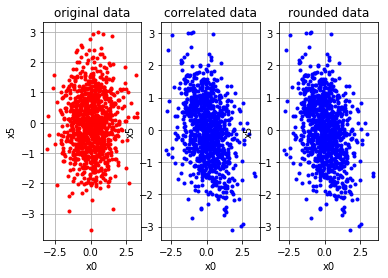

################### RF + LASSO, ridge, linear with extra term in ols ################

MSE for random forest: 0.9023889170657019



/home/shijing/anaconda3/envs/algo-indc/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


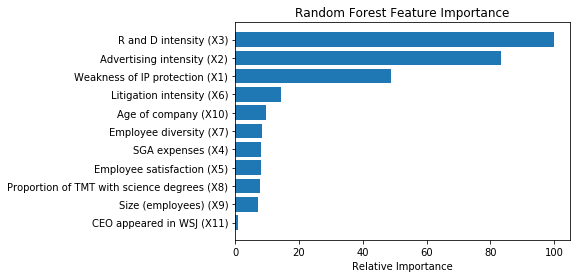

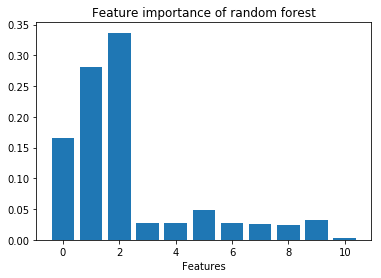

idx of features selected by Random Forest: [0, 1, 2, 5, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 7, 8, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 9-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 9, (0, 2), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 9, (0, 2), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.729
Model:                            OLS   Adj. R-squared (uncentered):              0.725
Method:                 Least Squares   F-statistic:                              165.6
Date:                Fri, 21 Feb 2020   Prob (F-statistic):                   2.69e-134
Time:                        15:12:11  

In [12]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)


################### gen X from normal+correlation=-0.3, gen Y from model variation 2 ##################################


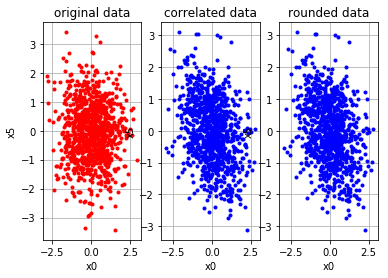

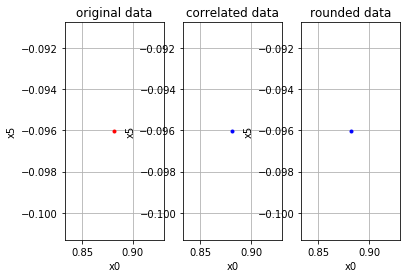

[ 0.4  0.2  0.5  0.   0.   0.   0.   0.   0.   0.   0.  -0.3 -0.7  0.1]
################### RF + LASSO, ridge, linear with extra term in ols ################

MSE for random forest: 0.8569051921008554



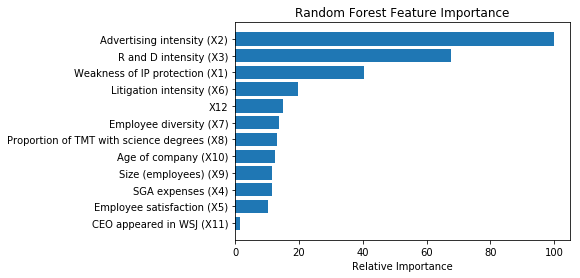

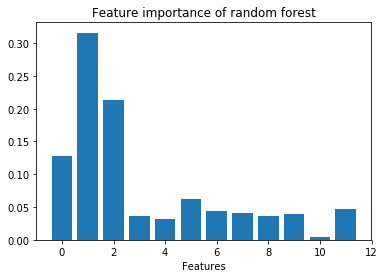

idx of features selected by Random Forest: [0, 1, 2, 5, 11]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 7, 8, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 11-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 11, (0, 2), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 11, (0, 2), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.636
Method:                 Least Squares   F-statistic:                              110.3
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   1.25e-104
Time:                        01:31:

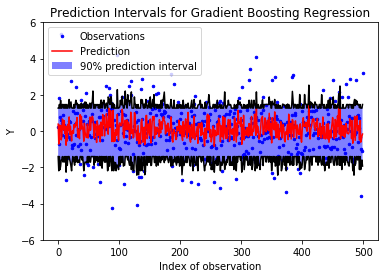

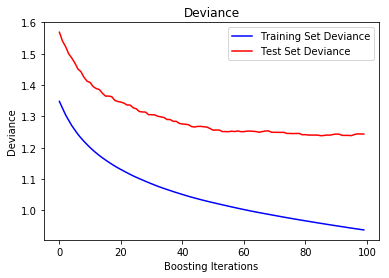

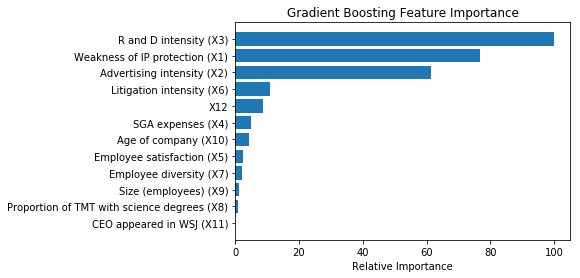

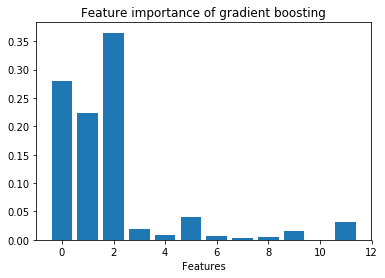

idx of features selected by Gradient Boosting: [0, 1, 2, 5, 11]
Computing regularization path using the coordinate descent lasso...


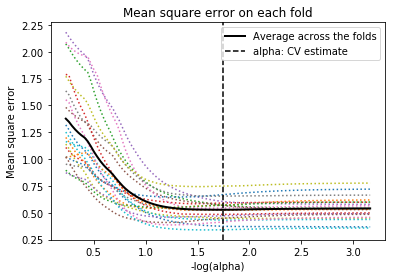


Alpha chosen for LASSO is:0.01794245871620669
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 7, 8, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 11-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 11, (0, 2), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 11, (0, 2), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.636
Method:                 Least Squares   F-statistic:                              110.3
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   1.25e-104
Time:                        01:31:03   Log-Like

Epoch 1/100
500/500 [==============================] - 1s 1ms/step - loss: 1.6438
Epoch 2/100
500/500 [==============================] - 0s 30us/step - loss: 1.3723
Epoch 3/100
500/500 [==============================] - 0s 16us/step - loss: 1.2520
Epoch 4/100
500/500 [==============================] - 0s 17us/step - loss: 1.1870
Epoch 5/100
500/500 [==============================] - 0s 26us/step - loss: 1.1150
Epoch 6/100
500/500 [==============================] - 0s 26us/step - loss: 1.0498
Epoch 7/100
500/500 [==============================] - 0s 22us/step - loss: 0.9944
Epoch 8/100
500/500 [==============================] - 0s 17us/step - loss: 0.9610
Epoch 9/100
500/500 [==============================] - 0s 14us/step - loss: 0.9194
Epoch 10/100
500/500 [==============================] - 0s 13us/step - loss: 0.8803
Epoch 11/100
500/500 [==============================] - 0s 16us/step - loss: 0.8430
Epoch 12/100
500/500 [==============================] - 0s 31us/step - loss: 0.8088
Ep

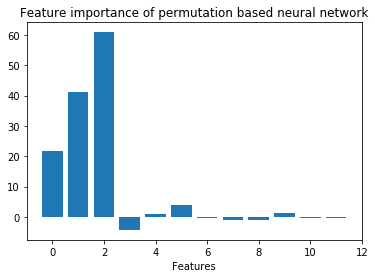

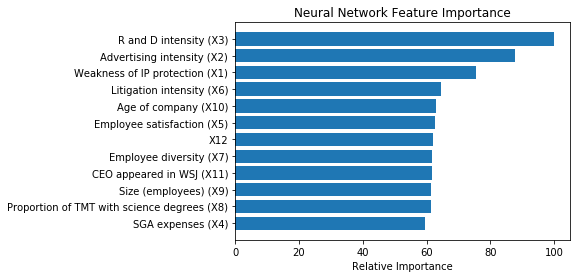

idx of features selected by neural network: [0, 1, 2, 5, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 8, 11, 17]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

the (5, 5)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (5, 5)]

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (5, 5)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.626
Method:                 Least Squares   F-statistic:                              105.5
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   1.24e-101
Time:                 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.628
Model:                            OLS   Adj. R-squared (uncentered):              0.623
Method:                 Least Squares   F-statistic:                              119.1
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   9.75e-102
Time:                        01:31:06   Log-Likelihood:                         -544.92
No. Observations:                 500   AIC:                                      1104.
Df Residuals:                     493   BIC:                                      1133.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [228]:
print ('################### gen X from normal+correlation=-0.3, gen Y from model variation 2 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(x_size=12,genCore='normal2',func= 'variation2',noise_sigma=noise_sigma,correlated=True)
print genData(x_size=12,genCore='normal2',func= 'variation2',noise_sigma=noise_sigma,correlated=True,sample_size=1)[2]
axis = determineAxis(sampleX,manifold='Isomap')

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsGBDTNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Neural Network + LASSO, ridge, linear with extra term in ols ################' + '\n'
neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7)


################### gen X from normal+correlation=-0.3, gen Y from model variation 1 ##################################


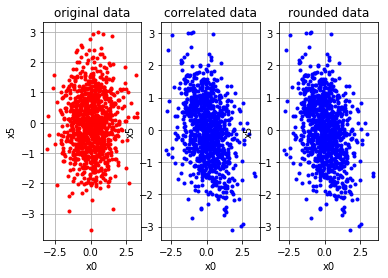

################### RF + LASSO, ridge, linear with extra term in ols ################

MSE for random forest: 0.833988758623789



/home/shijing/anaconda3/envs/algo-indc/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


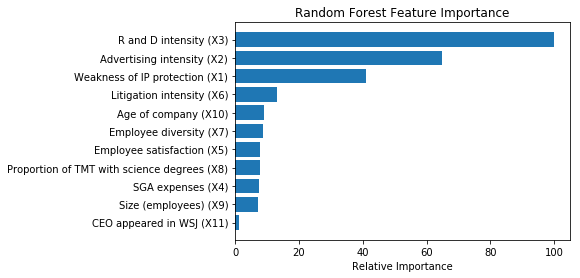

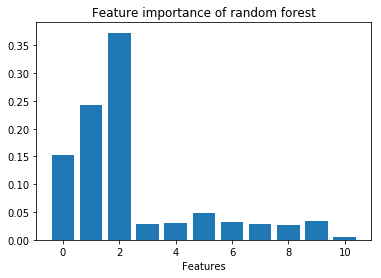

idx of features selected by Random Forest: [0, 1, 2, 5, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 5, 8, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 9-th variable in trainX

the (0, 0)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 9, (0, 0), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 9, (0, 0), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.722
Model:                            OLS   Adj. R-squared (uncentered):              0.717
Method:                 Least Squares   F-statistic:                              159.4
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   2.45e-131
Time:                        01:02:07  

MSE for gradient descent: 1.1982305460114924



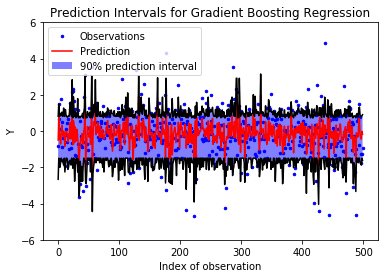

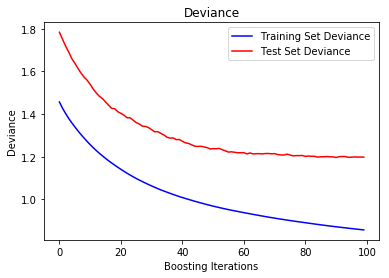

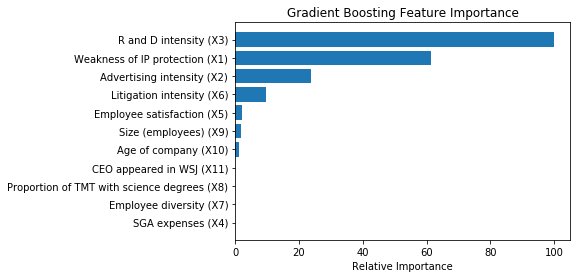

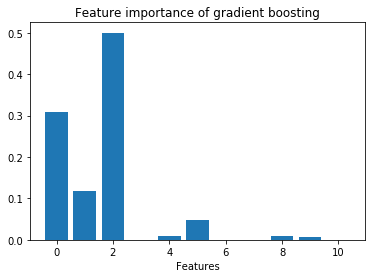

idx of features selected by Gradient Boosting: [0, 1, 2, 4, 5]
Computing regularization path using the coordinate descent lasso...


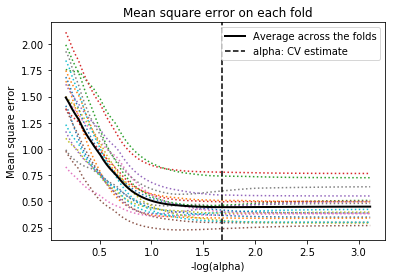


Alpha chosen for LASSO is:0.020538863576602916
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 5, 9, 11, 12]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 0)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

the (1, 4)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 0), (0, 5), 5, (1, 2), (1, 4), 4]

Terms for OLS are: [0, 1, 2, (0, 0), (0, 5), 5, (1, 2), (1, 4), 4]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.719
Method:                 Least Squares   F-statistic:                              142.8
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   5.35e-131
Time:                       






Epoch 1/100
500/500 [==============================] - 0s 625us/step - loss: 1.5501
Epoch 2/100
500/500 [==============================] - 0s 15us/step - loss: 1.3779
Epoch 3/100
500/500 [==============================] - 0s 15us/step - loss: 1.2515
Epoch 4/100
500/500 [==============================] - 0s 15us/step - loss: 1.1448
Epoch 5/100
500/500 [==============================] - 0s 17us/step - loss: 1.0608
Epoch 6/100
500/500 [==============================] - 0s 21us/step - loss: 0.9975
Epoch 7/100
500/500 [==============================] - 0s 14us/step - loss: 0.9397
Epoch 8/100
500/500 [==============================] - 0s 13us/step - loss: 0.8824
Epoch 9/100
500/500 [==============================] - 0s 29us/step - loss: 0.8343
Epoch 10/100
500/500 [==============================] - 0s 13us/step - loss: 0.7903
Epoch 11/100
500/500 [==============================] - 0s 17us/step - loss: 0.7515
Epoch 12/100
500/500 [==============================] - 0s 13us/step - loss: 0.

Epoch 86/100
500/500 [==============================] - 0s 18us/step - loss: 0.1206
Epoch 87/100
500/500 [==============================] - 0s 22us/step - loss: 0.1168
Epoch 88/100
500/500 [==============================] - 0s 20us/step - loss: 0.1157
Epoch 89/100
500/500 [==============================] - 0s 37us/step - loss: 0.1132
Epoch 90/100
500/500 [==============================] - 0s 20us/step - loss: 0.1114
Epoch 91/100
500/500 [==============================] - 0s 16us/step - loss: 0.1094
Epoch 92/100
500/500 [==============================] - 0s 17us/step - loss: 0.1085
Epoch 93/100
500/500 [==============================] - 0s 38us/step - loss: 0.1081
Epoch 94/100
500/500 [==============================] - 0s 26us/step - loss: 0.1051
Epoch 95/100
500/500 [==============================] - 0s 25us/step - loss: 0.1013
Epoch 96/100
500/500 [==============================] - 0s 25us/step - loss: 0.1007
Epoch 97/100
500/500 [==============================] - 0s 14us/step - loss:

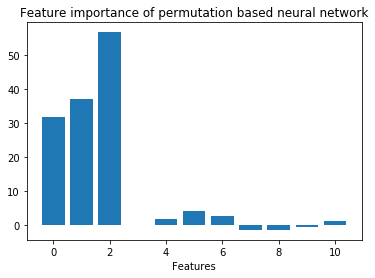

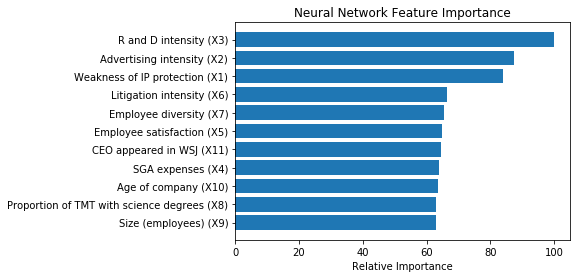

idx of features selected by neural network: [0, 1, 2, 5, 6]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 5, 8, 9, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 0)-th variable in trainX

the (0, 5)-th variable in trainX

the (0, 6)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 0), (0, 5), 5, (0, 6), 6, (1, 2)]

Terms for OLS are: [0, 1, 2, (0, 0), (0, 5), 5, (0, 6), 6, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.721
Model:                            OLS   Adj. R-squared (uncentered):              0.716
Method:                 Least Squares   F-statistic:                              140.9
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   5.68e-130
Time:            

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.711
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              173.4
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   1.39e-128
Time:                        01:02:11   Log-Likelihood:                         -550.53
No. Observations:                 500   AIC:                                      1115.
Df Residuals:                     493   BIC:                                      1145.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [60]:
print ('################### gen X from normal+correlation=-0.3, gen Y from model variation 1 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='variation1',noise_sigma=noise_sigma,correlated=True)

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsGBDTNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Neural Network + LASSO, ridge, linear with extra term in ols ################' + '\n'
neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7)


########################## gen X from normal+correlation=-0.3 ##################################


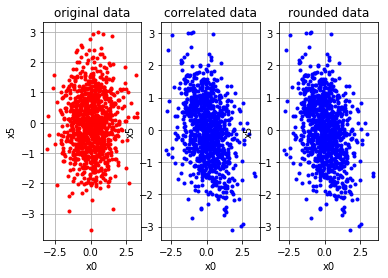

################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################

MSE for gradient descent: 1.37523023377414



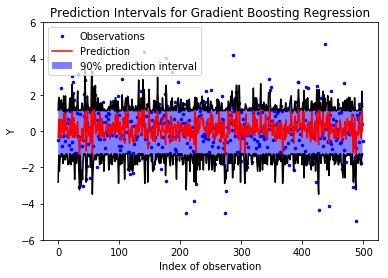

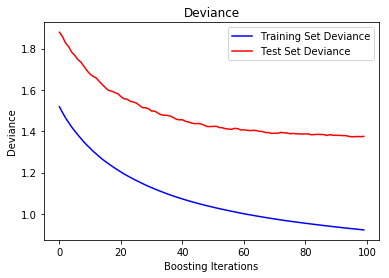

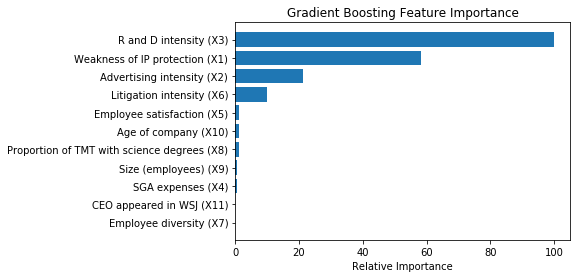

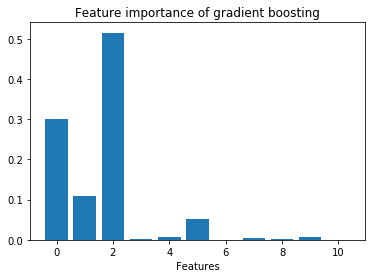

idx of features selected by Gradient Boosting: [0, 1, 2, 4, 5]
Computing regularization path using the coordinate descent lasso...


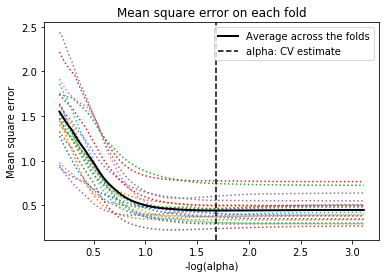


Alpha chosen for LASSO is:0.020633259884776906
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 9, 11, 12]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

the (1, 4)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (1, 4), 4]

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (1, 4), 4]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.726
Method:                 Least Squares   F-statistic:                              148.5
Date:                Thu, 23 Jan 2020   Prob (F-statistic):                   4.95e-134
Time:                       

In [48]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

print '################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsGBDTNewX(sampleX,sampleY,XFsize=5,Psize=7)

In [48]:
print ('################### gen X from normal+correlation=-0.3, gen Y from model variation 2 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(x_size=12,genCore='normal2',func= 'variation2',noise_sigma=noise_sigma,correlated=True)

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsGBDTNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Neural Network + LASSO, ridge, linear with extra term in ols ################' + '\n'
neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7)


################### gen X from normal+correlation=-0.3, gen Y from model variation 2 ##################################


TypeError: genCorrX() got an unexpected keyword argument 'sample_size'

################# gen X from normal+correlation=-0.3, gen Y from model variation 3 ##################################


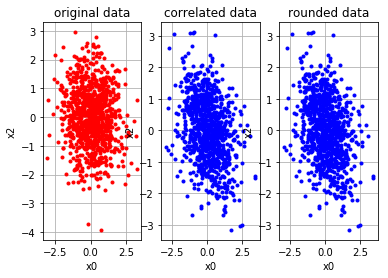

################### RF + LASSO, ridge, linear with extra term in ols ################

MSE for random forest: 1.0607023876502881



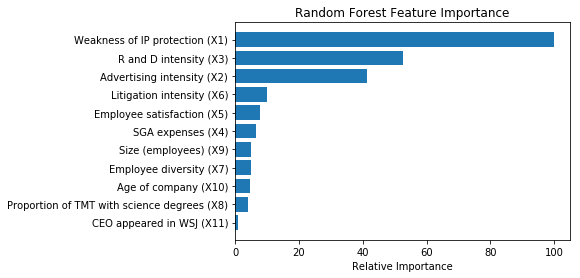

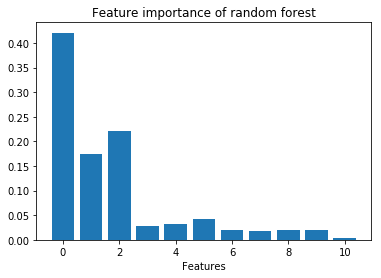

idx of features selected by Random Forest: [0, 1, 2, 4, 5]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 3, 5, 9, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 4-th variable in trainX

the (0, 0)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 4, (0, 0), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 4, (0, 0), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.550
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              75.23
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                    1.88e-80
Time:                        16:31:22  

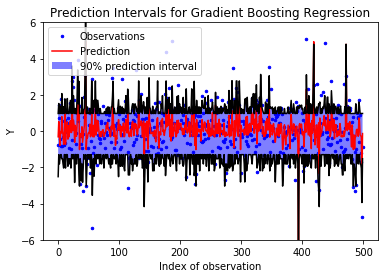

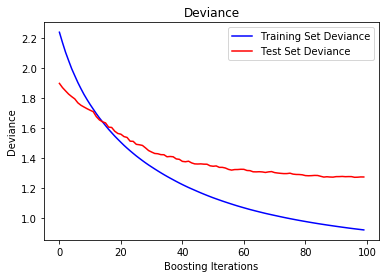

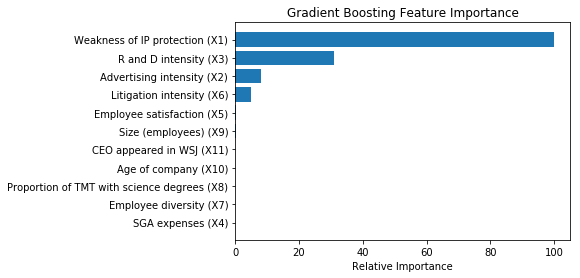

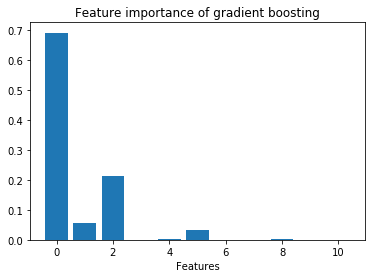

idx of features selected by Gradient Boosting: [0, 1, 2, 4, 5]
Computing regularization path using the coordinate descent lasso...


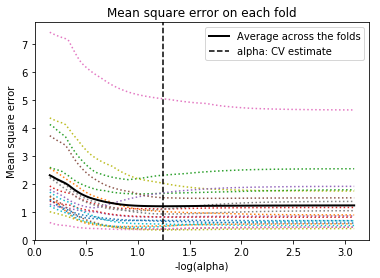


Alpha chosen for LASSO is:0.057647128474802876
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 3, 5, 9, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 4-th variable in trainX

the (0, 0)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 4, (0, 0), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 4, (0, 0), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.550
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                              75.23
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                    1.88e-80
Time:                        16:31:23   Log-Likeli

Epoch 1/100
500/500 [==============================] - 0s 652us/step - loss: 2.3187
Epoch 2/100
500/500 [==============================] - 0s 16us/step - loss: 2.0877
Epoch 3/100
500/500 [==============================] - 0s 14us/step - loss: 1.9195
Epoch 4/100
500/500 [==============================] - 0s 15us/step - loss: 1.7785
Epoch 5/100
500/500 [==============================] - 0s 18us/step - loss: 1.6457
Epoch 6/100
500/500 [==============================] - 0s 21us/step - loss: 1.5586
Epoch 7/100
500/500 [==============================] - 0s 18us/step - loss: 1.4846
Epoch 8/100
500/500 [==============================] - 0s 22us/step - loss: 1.4139
Epoch 9/100
500/500 [==============================] - 0s 15us/step - loss: 1.3613
Epoch 10/100
500/500 [==============================] - 0s 18us/step - loss: 1.3096
Epoch 11/100
500/500 [==============================] - 0s 24us/step - loss: 1.2698
Epoch 12/100
500/500 [==============================] - 0s 20us/step - loss: 1.2242


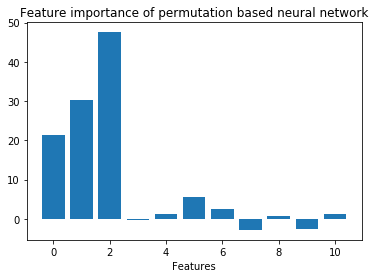

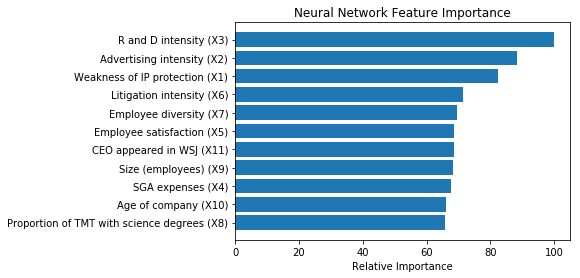

idx of features selected by neural network: [0, 1, 2, 5, 6]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 8, 9, 11, 17]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 5)-th variable in trainX

the (0, 6)-th variable in trainX

the (1, 2)-th variable in trainX

the (5, 5)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 5), 5, (0, 6), 6, (1, 2), (5, 5)]

Terms for OLS are: [0, 1, 2, (0, 5), 5, (0, 6), 6, (1, 2), (5, 5)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.569
Model:                            OLS   Adj. R-squared (uncentered):              0.561
Method:                 Least Squares   F-statistic:                              71.92
Date:                Wed, 22 Jan 2020   Prob (F-statistic):                    6.49e-84
Time:           

In [24]:
print ('################# gen X from normal+correlation=-0.3, gen Y from model variation 3 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='variation3',noise_sigma=noise_sigma,correlated=True)

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Gradient boosting + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsGBDTNewX(sampleX,sampleY,XFsize=5,Psize=7)

print '################### Neural Network + LASSO, ridge, linear with extra term in ols ################' + '\n'
neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7)


########################## gen X from normal+correlation=-0.3 ##################################


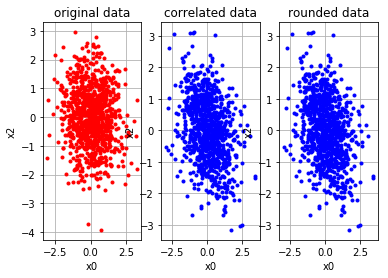

################### RF + LASSO, ridge, linear with extra term in ols ################

MSE for random forest: 0.9595623314095544



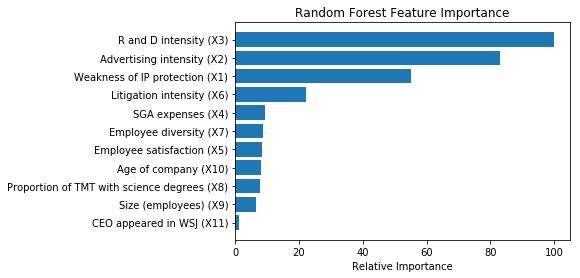

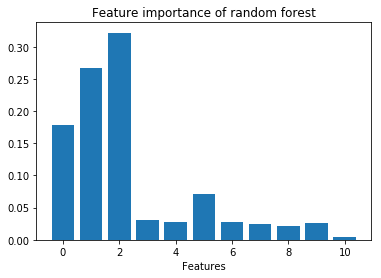

idx of features selected by Random Forest: [0, 1, 2, 3, 5]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 9, 11, 17]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

the (3, 3)-th variable in trainX

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (3, 3), 3]

Terms for OLS are: [0, 1, 2, (0, 2), (0, 5), 5, (1, 2), (3, 3), 3]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.740
Model:                            OLS   Adj. R-squared (uncentered):              0.736
Method:                 Least Squares   F-statistic:                              155.7
Date:                Mon, 13 Jan 2020   Prob (F-statistic):                   1.08e-137
Time:            

In [51]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

print '################### RF + LASSO, ridge, linear with extra term in ols ################' + '\n'
getMLresultsNewX(sampleX,sampleY,XFsize=5,Psize=7)


########################## gen X from normal+correlation=-0.3 ##################################


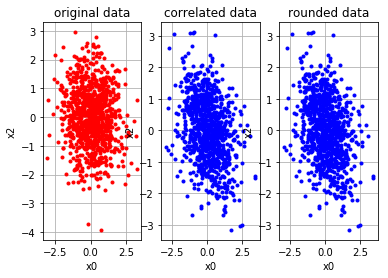

################### Neural Network + LASSO, ridge, linear with extra term in ols ################

Epoch 1/100
500/500 [==============================] - 0s 365us/step - loss: 1.6853
Epoch 2/100
500/500 [==============================] - 0s 18us/step - loss: 1.5076
Epoch 3/100
500/500 [==============================] - 0s 17us/step - loss: 1.3495
Epoch 4/100
500/500 [==============================] - 0s 15us/step - loss: 1.2349
Epoch 5/100
500/500 [==============================] - 0s 15us/step - loss: 1.1262
Epoch 6/100
500/500 [==============================] - 0s 15us/step - loss: 1.0420
Epoch 7/100
500/500 [==============================] - 0s 14us/step - loss: 0.9546
Epoch 8/100
500/500 [==============================] - 0s 23us/step - loss: 0.8891
Epoch 9/100
500/500 [==============================] - 0s 19us/step - loss: 0.8387
Epoch 10/100
500/500 [==============================] - 0s 16us/step - loss: 0.7836
Epoch 11/100
500/500 [==============================] - 0s 20us/step 

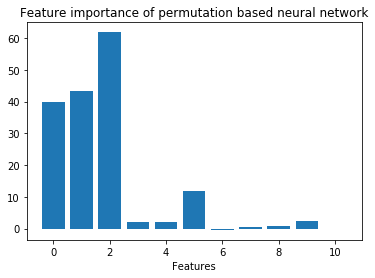

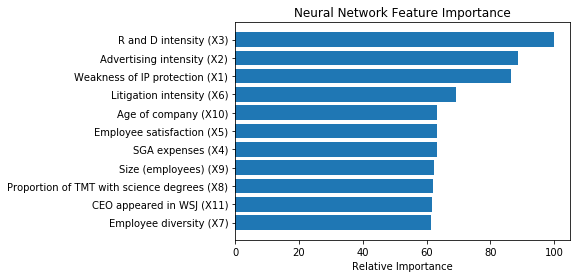

idx of features selected by neural network: [0, 1, 2, 5, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 7, 8, 11]
top 7 largest absolute coef in model lasso:

the 0-th variable in trainX

the 1-th variable in trainX

the 2-th variable in trainX

the 9-th variable in trainX

the (0, 2)-th variable in trainX

the (0, 5)-th variable in trainX

the (1, 2)-th variable in trainX

Terms for OLS are: [0, 1, 2, 9, (0, 2), (0, 5), 5, (1, 2)]

Terms for OLS are: [0, 1, 2, 9, (0, 2), (0, 5), 5, (1, 2)]

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.739
Method:                 Least Squares   F-statistic:                              177.7
Date:                Mon, 13 Jan 2020   Prob (F-statistic):                   8.15e-140
Time:                        01:17:49 

In [63]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
np.random.seed(42)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

print '################### Neural Network + LASSO, ridge, linear with extra term in ols ################' + '\n'
neuralNetFeatureImportance(sampleX, sampleY, XFsize=5, Psize=7)


########################## gen X from normal+correlation=-0.3 ##################################


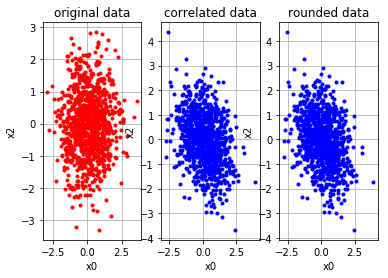

###Plot false positive rate for different k###

When number of folds is: 2

results for 0-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 7]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 8, 11, 13]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (0, 5), (1, 2), (1, 7)]
features selected after Ols based on pvalue:[0 1 2 (0, 2) (0, 5) (1, 2)]

results for 1-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 8]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 8, 10, 11]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (0, 5), (1, 1), (1, 2)]
features selected after Ols based on pvalue:[0 1 2 (0, 2) (0, 5) (1, 1) (1, 2)]


common parts in all the selected features of subsamples:[0 1 2 (0, 2) (0, 5) (1, 2)]

the true positive portion: 1.0 

the number of false positive:0

the false positive portion:0.0

When number of folds is: 3

results for 0-th subsample
idx of features selected b

idx of features selected by Random Forest: [0, 1, 2, 4, 7]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 3, 4, 11, 13]
top 7 largest absolute coef in model lasso:
[0, 1, 2, 4, 7, (1, 2), (1, 7)]
features selected after Ols based on pvalue:[0 2 (1, 2)]

results for 3-th subsample
idx of features selected by Random Forest: [2, 3, 5, 6, 7]
lasso:

idx of coefficient with largest absolute value: [0, 1, 5, 12, 15, 17, 18]
top 7 largest absolute coef in model lasso:
[2, 3, (2, 2), (3, 6), (5, 6), (6, 6), (6, 7)]
features selected after Ols based on pvalue:[2 3 (2, 2)]

results for 4-th subsample
idx of features selected by Random Forest: [0, 1, 2, 4, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 11, 12, 13]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (1, 2), (1, 4), (1, 9)]
features selected after Ols based on pvalue:[1 2 (0, 2) (1, 2)]

results for 5-th subsample
idx of features selected by Random Forest: [0, 2, 3, 5, 8]
lasso:

idx of features selected by Random Forest: [0, 2, 4, 5, 8]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 4, 6, 10, 18]
top 7 largest absolute coef in model lasso:
[0, 2, 4, 8, (0, 2), (2, 2), (5, 8)]
features selected after Ols based on pvalue:[0 (0, 2)]

results for 4-th subsample
idx of features selected by Random Forest: [0, 2, 3, 7, 9]
lasso:

idx of coefficient with largest absolute value: [1, 2, 4, 5, 9, 11, 19]
top 7 largest absolute coef in model lasso:
[2, 3, 9, (0, 0), (0, 9), (2, 3), (9, 9)]
features selected after Ols based on pvalue:[2]

results for 5-th subsample
idx of features selected by Random Forest: [0, 1, 2, 8, 9]
lasso:

idx of coefficient with largest absolute value: [2, 4, 7, 9, 10, 11, 13]
top 7 largest absolute coef in model lasso:
[2, 9, (0, 2), (0, 9), (1, 1), (1, 2), (1, 9)]
features selected after Ols based on pvalue:[2 (1, 1) (1, 2)]

results for 6-th subsample
idx of features selected by Random Forest: [0, 1, 2, 8, 9]
lasso:

idx of c

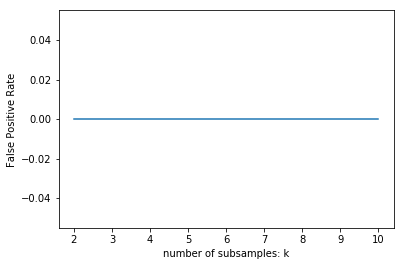

In [40]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
# np.random.seed(0)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

axis = determineAxis(sampleX,manifold='Isomap')
#################Linear Regresson on 2 second-order items with k non-overlapping subsamples,
#################model in ['lasso','RandomForest','OLS']
print '###Plot false positive rate for different k###' + '\n'
falsePositiveRate = []
for k in range(2,11):
    print "When number of folds is: " + str(k) + '\n'
    falsePositiveRate.append(getSubsampleResults(sampleX,sampleY,fold=k)[1])
print "List of false positive rate for different num of folds: " + str(falsePositiveRate)
x = range(2,11)
y = falsePositiveRate
plt.xlabel('number of subsamples: k')
plt.ylabel('False Positive Rate')
plt.plot(x,y)
plt.show()


########################## gen X from normal+correlation=-0.3 ##################################


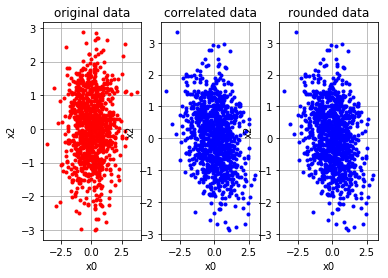

###Plot true positive rate for different k###

When number of folds is: 2

results for 0-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 6]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 8, 11, 12]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (0, 5), (1, 2), (1, 5)]
features selected after Ols based on pvalue:[0 1 2 (0, 2) (0, 5) (1, 2)]

results for 1-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 6]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 8, 11, 16]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (0, 5), (1, 2), (2, 6)]
features selected after Ols based on pvalue:[0 1 2 (0, 2) (0, 5) (1, 2)]


common parts in all the selected features of subsamples:[0 1 2 (0, 2) (0, 5) (1, 2)]

the true positive portion: 1.0 

the number of false positive:0

the false positive portion:0.0

When number of folds is: 3

results for 0-th subsample
idx of features selected by Random

idx of features selected by Random Forest: [0, 1, 2, 3, 5]
lasso:

idx of coefficient with largest absolute value: [0, 2, 6, 7, 9, 11, 15]
top 7 largest absolute coef in model lasso:
[0, 2, (0, 1), (0, 2), (0, 5), (1, 2), (2, 3)]
features selected after Ols based on pvalue:[0 2 (0, 2) (0, 5) (1, 2)]

results for 3-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 9]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 6, 8, 11, 13]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 1), (0, 5), (1, 2), (1, 9)]
features selected after Ols based on pvalue:[0 2 (0, 5) (1, 2)]

results for 4-th subsample
idx of features selected by Random Forest: [0, 1, 2, 5, 7]
lasso:

idx of coefficient with largest absolute value: [0, 2, 3, 4, 7, 8, 11]
top 7 largest absolute coef in model lasso:
[0, 2, 5, 7, (0, 2), (0, 5), (1, 2)]
features selected after Ols based on pvalue:[0 2 (1, 2)]

results for 5-th subsample
idx of features selected by Random Forest: [0, 1, 

idx of features selected by Random Forest: [1, 2, 3, 8, 9]
lasso:

idx of coefficient with largest absolute value: [1, 4, 6, 9, 11, 15, 16]
top 7 largest absolute coef in model lasso:
[2, 9, (1, 2), (1, 9), (2, 3), (3, 8), (3, 9)]
features selected after Ols based on pvalue:[2 9 (1, 2) (2, 3)]

results for 5-th subsample
idx of features selected by Random Forest: [0, 1, 2, 3, 5]
lasso:

idx of coefficient with largest absolute value: [0, 1, 2, 7, 9, 11, 13]
top 7 largest absolute coef in model lasso:
[0, 1, 2, (0, 2), (0, 5), (1, 2), (1, 5)]
features selected after Ols based on pvalue:[0 1 2 (0, 2) (0, 5) (1, 2)]

results for 6-th subsample
idx of features selected by Random Forest: [1, 2, 4, 5, 6]
lasso:

idx of coefficient with largest absolute value: [0, 1, 3, 6, 7, 11, 12]
top 7 largest absolute coef in model lasso:
[1, 2, 5, (1, 2), (1, 4), (2, 4), (2, 5)]
features selected after Ols based on pvalue:[2 (1, 2)]

results for 7-th subsample
idx of features selected by Random Forest: 

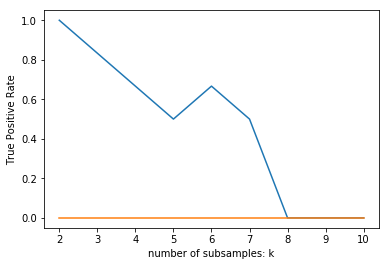

In [41]:
print ('########################## gen X from normal+correlation=-0.3 ##################################')
# np.random.seed(0)
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

axis = determineAxis(sampleX,manifold='Isomap')
#################Linear Regresson on 2 second-order items with k non-overlapping subsamples,
#################model in ['lasso','RandomForest','OLS']
print '###Plot true positive rate for different k###' + '\n'
truerate = []
for k in range(2,11):
    print "When number of folds is: " + str(k) + "\n"
    truerate.append(getSubsampleResults(sampleX,sampleY,fold=k))

print("list of true positive rate for different num of folds:", truerate)

x = range(2,11)
y = truerate

plt.xlabel('number of subsamples: k')
plt.ylabel('True Positive Rate')
plt.plot(x,y)
plt.show()
# getSubsampleResults(sampleX,sampleY,fold=5)


########################## gen X from normal without correlation ##################################
OLSModel for all degree 1 variables:

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.280
Model:                            OLS   Adj. R-squared (uncentered):              0.272
Method:                 Least Squares   F-statistic:                              34.98
Date:                Thu, 19 Dec 2019   Prob (F-statistic):                    2.34e-63
Time:                        21:16:22   Log-Likelihood:                         -1388.0
No. Observations:                1000   AIC:                                      2798.
Df Residuals:                     989   BIC:                                      2852.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                 

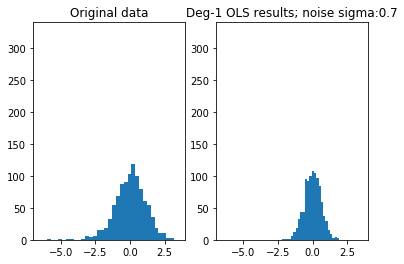

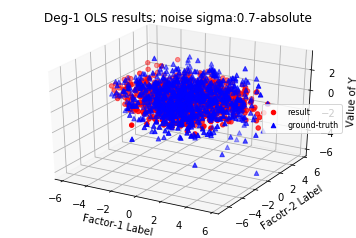

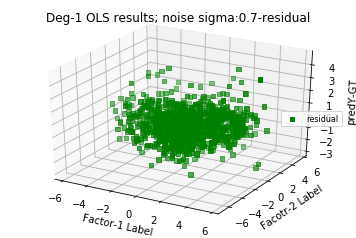

OLSModel for ONE degree 2 variables:

Top p-val combination:

(0, 2), with 4 p-vals <= 0.0001

3 combinations that have a deg-2 item with p value <= 0.0001
set verbose=True to view

OLSModel for Two degree 2 variables:

Top p-val combination:

((0, 0), (2, 2)), with 5 p-vals <= 0.0001

7 combinations that have BOTH TWO deg-2 item with p value <= 0.0001

set verbose=True to view

196 combinations that have at least ONE deg-2 item with p value <= 0.0001:

set verbose=True to view

OLSModel for all degree 2 variables:

Corresponding Xs:

X(0, 0):0
X(0, 1):1
X(0, 2):2
X(0, 3):3
X(0, 4):4
X(0, 5):5
X(0, 6):6
X(0, 7):7
X(0, 8):8
X(0, 9):9
X(0, 10):10
X(1, 1):11
X(1, 2):12
X(1, 3):13
X(1, 4):14
X(1, 5):15
X(1, 6):16
X(1, 7):17
X(1, 8):18
X(1, 9):19
X(1, 10):20
X(2, 2):21
X(2, 3):22
X(2, 4):23
X(2, 5):24
X(2, 6):25
X(2, 7):26
X(2, 8):27
X(2, 9):28
X(2, 10):29
X(3, 3):30
X(3, 4):31
X(3, 5):32
X(3, 6):33
X(3, 7):34
X(3, 8):35
X(3, 9):36
X(3, 10):37
X(4, 4):38
X(4, 5):39
X(4, 6):40
X(4, 7):41
X(4

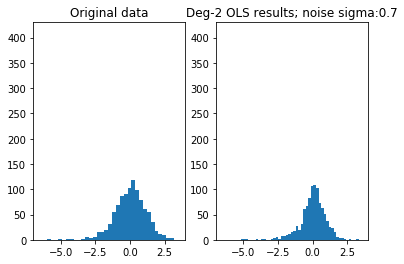

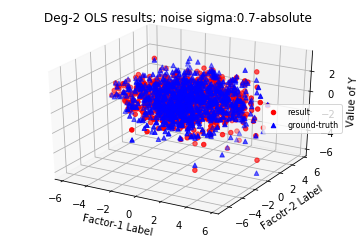

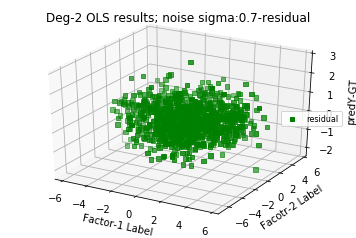

y~X0+X1+X2+X3+X4+X5+X6+X7+X8+X9+X10+X0*X0+X0*X1+X0*X2+X0*X3+X0*X4+X0*X5+X0*X6+X0*X7+X0*X8+X0*X9+X0*X10+X1*X1+X1*X2+X1*X3+X1*X4+X1*X5+X1*X6+X1*X7+X1*X8+X1*X9+X1*X10+X2*X2+X2*X3+X2*X4+X2*X5+X2*X6+X2*X7+X2*X8+X2*X9+X2*X10+X3*X3+X3*X4+X3*X5+X3*X6+X3*X7+X3*X8+X3*X9+X3*X10+X4*X4+X4*X5+X4*X6+X4*X7+X4*X8+X4*X9+X4*X10+X5*X5+X5*X6+X5*X7+X5*X8+X5*X9+X5*X10+X6*X6+X6*X7+X6*X8+X6*X9+X6*X10+X7*X7+X7*X8+X7*X9+X7*X10+X8*X8+X8*X9+X8*X10+X9*X9+X9*X10+X10*X10
Start:  AIC=-653.98
y ~ X0 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X0 * 
    X0 + X0 * X1 + X0 * X2 + X0 * X3 + X0 * X4 + X0 * X5 + X0 * 
    X6 + X0 * X7 + X0 * X8 + X0 * X9 + X0 * X10 + X1 * X1 + X1 * 
    X2 + X1 * X3 + X1 * X4 + X1 * X5 + X1 * X6 + X1 * X7 + X1 * 
    X8 + X1 * X9 + X1 * X10 + X2 * X2 + X2 * X3 + X2 * X4 + X2 * 
    X5 + X2 * X6 + X2 * X7 + X2 * X8 + X2 * X9 + X2 * X10 + X3 * 
    X3 + X3 * X4 + X3 * X5 + X3 * X6 + X3 * X7 + X3 * X8 + X3 * 
    X9 + X3 * X10 + X4 * X4 + X4 * X5 + X4 * X6 + X4 * X7 + X4 * 
    X8 + X4

         Df Sum of Sq    RSS     AIC
- X0:X7   1      0.00 454.77 -661.97
- X0:X1   1      0.00 454.77 -661.96
- X6:X8   1      0.06 454.82 -661.85
- X4:X9   1      0.06 454.83 -661.84
- X0:X10  1      0.07 454.84 -661.82
- X0:X9   1      0.07 454.84 -661.81
- X4:X7   1      0.08 454.84 -661.81
- X0:X5   1      0.08 454.85 -661.79
- X1:X3   1      0.10 454.87 -661.74
- X1:X5   1      0.13 454.90 -661.69
- X3:X7   1      0.14 454.91 -661.66
- X5:X10  1      0.17 454.94 -661.59
- X3:X4   1      0.20 454.97 -661.52
- X9:X10  1      0.20 454.97 -661.52
- X4:X10  1      0.21 454.97 -661.52
- X2:X3   1      0.21 454.98 -661.51
- X2:X6   1      0.22 454.99 -661.48
- X1:X9   1      0.24 455.00 -661.45
- X0:X3   1      0.25 455.02 -661.42
- X4:X6   1      0.27 455.04 -661.37
- X4:X8   1      0.28 455.04 -661.36
- X5:X6   1      0.28 455.05 -661.35
- X2:X4   1      0.29 455.05 -661.34
- X1:X6   1      0.30 455.07 -661.30
- X5:X8   1      0.35 455.12 -661.20
- X2:X9   1      0.38 455.14 -661.14
-

         Df Sum of Sq    RSS     AIC
- X0:X5   1      0.09 454.98 -669.49
- X4:X7   1      0.09 454.98 -669.49
- X0:X10  1      0.09 454.99 -669.49
- X0:X9   1      0.09 454.99 -669.48
- X1:X3   1      0.10 455.00 -669.47
- X1:X5   1      0.12 455.02 -669.41
- X3:X7   1      0.13 455.03 -669.39
- X5:X10  1      0.18 455.08 -669.28
- X9:X10  1      0.19 455.08 -669.27
- X3:X4   1      0.19 455.09 -669.25
- X1:X9   1      0.22 455.12 -669.20
- X2:X3   1      0.22 455.12 -669.19
- X4:X10  1      0.23 455.12 -669.18
- X2:X6   1      0.24 455.14 -669.15
- X0:X3   1      0.25 455.15 -669.13
- X4:X6   1      0.27 455.16 -669.10
- X4:X8   1      0.28 455.17 -669.08
- X5:X6   1      0.28 455.18 -669.06
- X2:X4   1      0.31 455.20 -669.01
- X1:X6   1      0.32 455.21 -668.99
- X5:X8   1      0.38 455.28 -668.84
- X2:X9   1      0.39 455.29 -668.82
- X3:X10  1      0.39 455.29 -668.82
- X2:X7   1      0.40 455.30 -668.81
- X3:X5   1      0.41 455.31 -668.79
- X3:X6   1      0.51 455.41 -668.56
-

         Df Sum of Sq    RSS     AIC
- X1:X3   1      0.10 455.34 -676.71
- X1:X5   1      0.12 455.36 -676.67
- X3:X7   1      0.16 455.40 -676.58
- X5:X10  1      0.18 455.42 -676.54
- X9:X10  1      0.18 455.42 -676.54
- X4:X10  1      0.20 455.44 -676.50
- X2:X6   1      0.21 455.45 -676.48
- X3:X4   1      0.21 455.45 -676.47
- X2:X3   1      0.23 455.47 -676.43
- X4:X6   1      0.24 455.48 -676.41
- X1:X9   1      0.25 455.49 -676.38
- X0:X3   1      0.26 455.50 -676.35
- X2:X4   1      0.27 455.51 -676.34
- X4:X8   1      0.29 455.53 -676.30
- X5:X6   1      0.30 455.54 -676.28
- X1:X6   1      0.30 455.54 -676.26
- X2:X7   1      0.36 455.60 -676.13
- X5:X8   1      0.38 455.62 -676.10
- X3:X5   1      0.42 455.66 -676.00
- X2:X9   1      0.43 455.66 -676.00
- X3:X10  1      0.43 455.67 -675.99
- X1:X8   1      0.49 455.73 -675.86
- X8:X9   1      0.50 455.74 -675.83
- X3:X6   1      0.52 455.76 -675.80
- X6:X7   1      0.63 455.87 -675.56
- X7:X9   1      0.75 455.99 -675.28
-

         Df Sum of Sq    RSS     AIC
- X3:X4   1      0.17 455.94 -683.38
- X2:X3   1      0.19 455.96 -683.34
- X2:X6   1      0.19 455.96 -683.34
- X9:X10  1      0.21 455.98 -683.31
- X4:X10  1      0.21 455.98 -683.31
- X5:X6   1      0.25 456.02 -683.23
- X2:X4   1      0.26 456.03 -683.19
- X1:X9   1      0.27 456.04 -683.18
- X4:X6   1      0.28 456.05 -683.16
- X0:X3   1      0.31 456.08 -683.08
- X4:X8   1      0.32 456.08 -683.08
- X1:X6   1      0.32 456.09 -683.07
- X5:X8   1      0.34 456.11 -683.01
- X2:X7   1      0.36 456.13 -682.97
- X3:X10  1      0.40 456.17 -682.89
- X3:X5   1      0.40 456.17 -682.89
- X2:X9   1      0.41 456.18 -682.86
- X1:X8   1      0.47 456.24 -682.74
- X8:X9   1      0.47 456.24 -682.74
- X3:X6   1      0.51 456.28 -682.64
- X6:X7   1      0.67 456.44 -682.29
- X7:X9   1      0.68 456.45 -682.28
- X3:X9   1      0.79 456.56 -682.04
- X2:X5   1      0.81 456.58 -681.98
- X0:X6   1      0.90 456.67 -681.80
- X6:X10  1      0.91 456.68 -681.78
-

         Df Sum of Sq    RSS     AIC
- X1:X9   1      0.25 456.97 -691.14
- X0:X3   1      0.25 456.97 -691.13
- X5:X6   1      0.27 456.99 -691.10
- X9:X10  1      0.27 456.99 -691.09
- X1:X6   1      0.31 457.04 -691.00
- X5:X8   1      0.32 457.04 -690.99
- X4:X6   1      0.33 457.05 -690.95
- X2:X7   1      0.36 457.09 -690.89
- X4:X8   1      0.37 457.09 -690.88
- X3:X5   1      0.38 457.10 -690.85
- X8:X9   1      0.41 457.13 -690.78
- X3:X10  1      0.42 457.14 -690.77
- X2:X9   1      0.46 457.18 -690.68
- X1:X8   1      0.52 457.24 -690.54
- X3:X6   1      0.61 457.33 -690.35
- X2:X5   1      0.69 457.42 -690.16
- X6:X7   1      0.75 457.47 -690.04
- X7:X9   1      0.76 457.48 -690.03
- X3:X9   1      0.87 457.59 -689.78
- X0:X6   1      0.88 457.60 -689.75
<none>                456.72 -689.68
- X1:X10  1      0.95 457.67 -689.60
- X6:X10  1      1.01 457.73 -689.47
- X6:X9   1      1.04 457.76 -689.42
- X8:X10  1      1.08 457.80 -689.32
- X7:X10  1      1.14 457.86 -689.19
-

         Df Sum of Sq    RSS     AIC
- X9:X10  1      0.33 458.40 -698.01
- X4:X6   1      0.34 458.40 -698.00
- X4:X8   1      0.37 458.43 -697.94
- X2:X9   1      0.37 458.44 -697.94
- X2:X7   1      0.38 458.45 -697.91
- X8:X9   1      0.40 458.47 -697.87
- X3:X10  1      0.41 458.47 -697.86
- X3:X5   1      0.42 458.49 -697.83
- X1:X8   1      0.52 458.58 -697.62
- X3:X6   1      0.57 458.63 -697.50
- X7:X9   1      0.71 458.78 -697.19
- X2:X5   1      0.75 458.82 -697.10
- X1:X10  1      0.76 458.83 -697.08
- X6:X7   1      0.87 458.93 -696.85
<none>                458.07 -696.74
- X0:X6   1      0.94 459.00 -696.70
- X3:X9   1      0.94 459.01 -696.69
- X6:X10  1      0.95 459.02 -696.66
- X0:X4   1      1.13 459.20 -696.27
- X6:X9   1      1.15 459.21 -696.24
- X8:X10  1      1.19 459.26 -696.14
- X5:X7   1      1.27 459.34 -695.97
- X7:X10  1      1.29 459.35 -695.94
- X7:X8   1      1.38 459.45 -695.72
- X2:X8   1      1.52 459.59 -695.42
- X4:X5   1      1.77 459.84 -694.88
-

         Df Sum of Sq    RSS     AIC
- X4:X8   1      0.44 460.51 -705.41
- X1:X8   1      0.47 460.55 -705.34
- X3:X5   1      0.53 460.60 -705.23
- X2:X5   1      0.64 460.71 -704.99
- X3:X6   1      0.68 460.75 -704.90
- X1:X10  1      0.70 460.77 -704.85
- X7:X9   1      0.77 460.84 -704.69
- X6:X10  1      0.83 460.91 -704.56
- X6:X7   1      0.84 460.91 -704.55
<none>                460.07 -704.37
- X0:X4   1      0.95 461.02 -704.31
- X0:X6   1      1.01 461.09 -704.17
- X6:X9   1      1.08 461.15 -704.03
- X3:X9   1      1.12 461.19 -703.94
- X7:X10  1      1.14 461.22 -703.89
- X8:X10  1      1.19 461.26 -703.79
- X5:X7   1      1.22 461.29 -703.73
- X7:X8   1      1.28 461.36 -703.58
- X2:X8   1      1.50 461.57 -703.13
- X2:X10  1      1.77 461.85 -702.52
- X4:X5   1      1.79 461.86 -702.49
- X5:X9   1      3.54 463.61 -698.70
- X0:X8   1      7.44 467.51 -690.33
- X0:X2   1     75.23 535.30 -554.92
- X1:X2   1    359.67 819.74 -128.77

Step:  AIC=-705.41
y ~ X0 + X1 + X2 +

- X4:X5   1      1.78 465.94 -707.71
- X2:X10  1      1.91 466.07 -707.42
- X5:X9   1      3.32 467.48 -704.39
- X0:X8   1      7.73 471.89 -695.01
- X0:X2   1     76.03 540.19 -559.84
- X1:X2   1    366.79 830.95 -129.18

Step:  AIC=-709.69
y ~ X0 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X0:X2 + 
    X0:X6 + X0:X8 + X1:X2 + X2:X8 + X2:X10 + X3:X9 + X4:X5 + 
    X5:X9 + X6:X7 + X6:X9 + X6:X10 + X7:X8 + X7:X9 + X7:X10 + 
    X8:X10

         Df Sum of Sq    RSS     AIC
- X7:X9   1      0.78 465.80 -710.01
- X7:X10  1      0.81 465.82 -709.95
<none>                465.01 -709.69
- X6:X10  1      1.03 466.04 -709.48
- X6:X7   1      1.05 466.06 -709.44
- X0:X6   1      1.19 466.20 -709.13
- X6:X9   1      1.19 466.21 -709.13
- X3:X9   1      1.36 466.37 -708.77
- X8:X10  1      1.40 466.41 -708.69
- X2:X8   1      1.51 466.52 -708.46
- X7:X8   1      1.80 466.81 -707.83
- X2:X10  1      1.81 466.82 -707.82
- X4:X5   1      1.91 466.92 -707.59
- X5:X9   1      3.28 468.29 -704.

ImportError: No module named cross_validation

In [8]:
print ('########################## gen X from normal without correlation ##################################')
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=False)

axis = determineAxis(sampleX,manifold='Isomap')
########################OLS Regression for 1-degree polynomials
resY = getOLSModelDegree1(sampleX, sampleY)
mse = mean_squared_error(sampleY, resY)
print 'Deg-1 OLS MSE:'+str(mse)+'\n'
pscr = pearsonr(sampleY, resY)
print 'Deg-1 OLS Pearson Corr:'+str(pscr)+'\n'
title = 'Deg-1 OLS results; noise sigma:'+str(noise_sigma)
plotHist(resY,sampleY,title)
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='absolute')
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='residual')

#######################OLS Regression for 2-degree polynomials
getOLSModelOneDegree2(sampleX,sampleY,0.0001)
getOLSModelTwoDegree2(sampleX,sampleY,0.0001)
resY = getOLSModelDegree2(sampleX, sampleY)
mse = mean_squared_error(sampleY, resY)
print 'Deg-2 OLS MSE:'+str(mse)+'\n'
pscr = pearsonr(sampleY, resY)
print 'Deg-2 OLS Pearson Corr:'+str(pscr)+'\n'
title = 'Deg-2 OLS results; noise sigma:'+str(noise_sigma)
plotHist(resY,sampleY,title)
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='absolute')
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='residual')

########################Step-wise regression##################
runStepwiseRegression(sampleX,sampleY)

#################Linear Regresson on 2 second-order items, model in ['lasso','ridge','Linear','RandomForest']
getMLresults(sampleX,sampleY,XFsize=5,Psize=7,manifold='determined',detX=axis,y_value='residual')
runDT(sampleX,sampleY,manifold='determined',detX=axis,y_value='residual',DT_depth=5)
print ('########################## gen X from normal+correlation=-0.3 ##################################')
noise_sigma = 0.7
sampleX, sampleY, gt_coef = genData(genCore='normal',func='1',noise_sigma=noise_sigma,correlated=True)

axis = determineAxis(sampleX,manifold='Isomap')
########################OLS Regression for 1-degree polynomials
resY = getOLSModelDegree1(sampleX, sampleY)
mse = mean_squared_error(sampleY, resY)
print 'Deg-1 OLS MSE:'+str(mse)+'\n'
pscr = pearsonr(sampleY, resY)
print 'Deg-1 OLS Pearson Corr:'+str(pscr)+'\n'
title = 'Deg-1 OLS results; noise sigma:'+str(noise_sigma)
plotHist(resY,sampleY,title)
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='absolute')
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='residual')

#######################OLS Regression for 2-degree polynomials
getOLSModelOneDegree2(sampleX,sampleY,0.0001)
getOLSModelTwoDegree2(sampleX,sampleY,0.0001)
resY = getOLSModelDegree2(sampleX, sampleY)
mse = mean_squared_error(sampleY, resY)
print 'Deg-2 OLS MSE:'+str(mse)+'\n'
pscr = pearsonr(sampleY, resY)
print 'Deg-2 OLS Pearson Corr:'+str(pscr)+'\n'
title = 'Deg-2 OLS results; noise sigma:'+str(noise_sigma)
plotHist(resY,sampleY,title)
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='absolute')
plotDistribution(resY,sampleY,sampleX,title,manifold='determined',detX=axis,y_value='residual')

########################Step-wise regression##################
runStepwiseRegression(sampleX,sampleY)

#################Linear Regresson on 2 second-order items, model in ['lasso','ridge','Linear','RandomForest']
getMLresults(sampleX,sampleY,XFsize=5,Psize=7,manifold='determined',detX=axis,y_value='residual')
runDT(sampleX,sampleY,manifold='determined',detX=axis,y_value='residual',DT_depth=5)